In [1]:
# Use LSTM to predict stock price

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader


In [3]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")
    print("Current device is mps")

Current device is mps


# Import and preprocess dataset

In [4]:
import pandas_datareader.data as web
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2022, 10, 30)
df = web.DataReader("GOOGL", "stooq", start, end)

In [5]:
df.sort_index(inplace = True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.50000,2.6015,2.39900,2.50850,894076000.0
2004-08-20,2.52525,2.7270,2.51250,2.70775,457144000.0
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0
...,...,...,...,...,...
2022-10-24,101.80000,102.7500,99.98000,102.52000,27176417.0
2022-10-25,102.90000,104.8200,102.72000,104.48000,40611375.0
2022-10-26,96.43000,98.3100,94.69000,94.93000,88279042.0


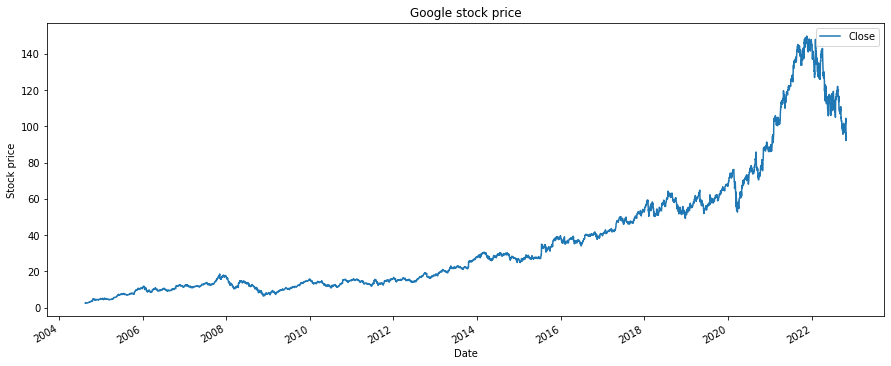

In [6]:
df[["Close"]].plot(figsize=(15,6))
plt.ylabel("Stock price")
plt.title("Google stock price")
plt.show()

In [7]:
df.describe()

,Open,High,Low,Close,Volume
count,4582.000000,4582.000000,4582.000000,4582.000000,4.581000e+03
mean,37.234385,37.610194,36.843978,37.234463,1.253231e+08
std,34.741803,35.113070,34.358235,34.741340,1.525965e+08
min,2.479750,2.543500,2.399000,2.500250,9.312760e+06
25%,12.571250,12.713875,12.433750,12.574250,3.263714e+07
50%,22.586000,22.750250,22.432250,22.601250,7.126800e+07
75%,53.346875,53.997750,52.725750,53.481125,1.552240e+08
max,151.250000,151.547000,148.899000,149.838000,1.644668e+09


In [8]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    1
dtype: int64

In [9]:
df.dropna(inplace=True, axis=0)

In [10]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.50000,2.6015,2.39900,2.50850,894076000.0
2004-08-20,2.52525,2.7270,2.51250,2.70775,457144000.0
2004-08-23,2.76875,2.8370,2.72625,2.73500,365488000.0
2004-08-24,2.78100,2.7900,2.58925,2.62175,305252000.0
2004-08-25,2.62400,2.7000,2.59700,2.65000,183956000.0
...,...,...,...,...,...
2022-10-24,101.80000,102.7500,99.98000,102.52000,27176417.0
2022-10-25,102.90000,104.8200,102.72000,104.48000,40611375.0
2022-10-26,96.43000,98.3100,94.69000,94.93000,88279042.0


## Scale the feature

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()

df["Close"] = scaler.fit_transform(df["Close"].values.reshape(-1, 1))

## Split the data

In [12]:
def load_data(stock, look_back):
    data_raw = stock.values
    data = []
    
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    X_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    X_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]
    
    return [X_train, y_train, X_test, y_test]

look_back = 10 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df[["Close"]], look_back)
print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

x_train.shape = (3657, 9, 1)
y_train.shape = (3657, 1)
x_test.shape = (914, 9, 1)
y_test.shape = (914, 1)


In [13]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

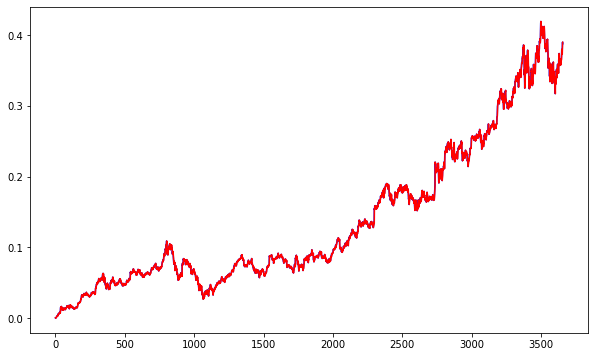

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.numpy(), color = "blue")
plt.plot(x_train.numpy()[:,-1,:], color = "red")
plt.show()

## Define key functions

In [99]:
def train_model(model, criterion = "MSE", optimiser = "Adam", learning_rate = 0.01, epochs = 200, verbose = 1):
    if criterion == "MSE":
        criterion = torch.nn.MSELoss(reduction="mean")
    if optimiser == "Adam":
        optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimiser == "SGD":
        optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)
        
    loss_history = np.zeros(epochs)

    
    for e in range(epochs):
        y_train_pred = model(x_train)[0]
        loss = criterion(y_train_pred[:,-1,:], y_train) 
        # loss = criterion(y_train_pred, y_train)             
        loss_history[e] = loss.item()
        

        if e % 10 == 0 and e > 0:
            if verbose == 1:
                print("Epoch:", e, "MSE:", loss.item())
            else:
                pass
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    return model, loss_history#, accuracy_history

In [16]:
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history)
    plt.xlabel("Training epochs")
    plt.ylabel("MSE loss")
    plt.title("Training MSE Loss")
    plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
import math

def plot_prediction(model, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    y_train_pred = model(x_train)[0][:,-1,:].detach().numpy()
    y_test_pred = model(x_test)[0][:,-1,:].detach().numpy()
    # y_train_pred = model(x_train)[0].detach().numpy()
    # y_test_pred = model(x_test)[0].detach().numpy()
    
    plt.figure(figsize=(30,10))
    plt.subplot(1,2,1)
    plt.plot(y_train_pred, color = "red", label = "Train prediction")
    plt.plot(y_train, color = "blue", label = "Train true values")
    plt.legend()
    plt.title("Training set")
    
    plt.subplot(1,2,2)
    plt.plot(y_test_pred, color = "red", label = "Test prediction")
    plt.plot(y_test, color = "blue", label = "Test true values")
    plt.legend()
    plt.title("Testing set")  
    
    # invert predictions
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))


# Baseline RNN model

Input size: Number of feature dimensions (e.g., number of data channels). Often set to 1

Sequence length: Length of data snippet used for learning.

Batch size: Number of sequences to input per epoch.

Hidden size: Number of units in the hidden layer.

Number of layers: Number of hidden layers stacked on each other.

In [18]:
# set layer parameters
input_size = 1 
hidden_size = 64
num_layers = 1

The hidden state should be initialized to zeros at the start of each sequence. Otherwise the model starts learning the sequence biased by the hidden states from the previous sequence, which could be totally different.

In [20]:
class RNNnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        
        #store parameters
        self.input_size = input_size  #numer of feature dimensions. We are only using one column, so its 1
        self.num_hidden = num_hidden  #number of units in the hidden layer
        self.num_layers = num_layers  #number of hidden layers stacked on each other
        # self.batchsize = batchsize
        #RNN layer
        self.rnn = nn.RNN(input_size, num_hidden, num_layers, batch_first = True)
        
        #Linear layer for output
        self.out = nn.Linear(num_hidden, 1) # we only need 1 output
        
    def forward(self, x):
        
        # print(f'Input: {list(x.shape)}')
        
        #initialize hiddent state for first input, x.size(0) is the batch size
        hidden = torch.zeros(self.num_layers, x.size(0), self.num_hidden)
        # print(f'Hidden: {list(hidden.shape)}')

        #run through the RNN layer
        y, hidden = self.rnn(x, hidden)
        # print(f'RNN-out: {list(y.shape)}') #output of rnn layer
        # print(f'RNN-hidden: {list(hidden.shape)}') #hidden state of rnn layer
        
        #pass the RNN output through the linear output layer
        output = self.out(y) #final output after passing to the linear layer
        # print(f'Ouput: {list(output.shape)}')
        
        return output, hidden
               

In [80]:
model = RNNnet(1, 64, 1)

In [81]:
trained_rnn, loss_history = train_model(model)

Epoch: 10 MSE: 0.014407284557819366
Epoch: 20 MSE: 0.004995342809706926
Epoch: 30 MSE: 0.0012304255506023765
Epoch: 40 MSE: 0.000552958867046982
Epoch: 50 MSE: 0.00016026946832425892
Epoch: 60 MSE: 3.8284666516119614e-05
Epoch: 70 MSE: 2.0467658032430336e-05
Epoch: 80 MSE: 2.426455102977343e-05
Epoch: 90 MSE: 1.790560781955719e-05
Epoch: 100 MSE: 1.6151641830219887e-05
Epoch: 110 MSE: 1.5969322703313082e-05
Epoch: 120 MSE: 1.5642410289729014e-05
Epoch: 130 MSE: 1.5368268577731214e-05
Epoch: 140 MSE: 1.5219076885841787e-05
Epoch: 150 MSE: 1.5062958482303657e-05
Epoch: 160 MSE: 1.4923453818482812e-05
Epoch: 170 MSE: 1.4791417015658226e-05
Epoch: 180 MSE: 1.4665924936707597e-05
Epoch: 190 MSE: 1.454567154723918e-05


## Visualise result

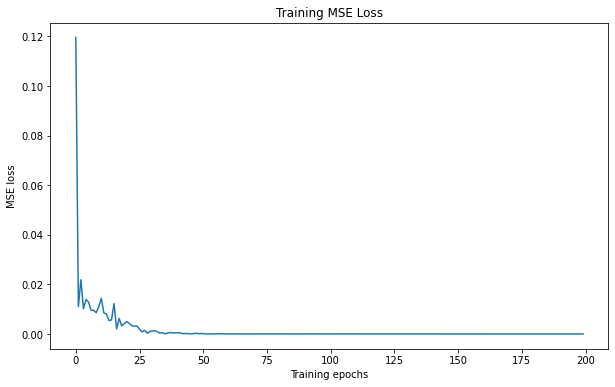

In [82]:
plot_loss(loss_history)

Train Score: 0.56 RMSE
Test Score: 9.41 RMSE


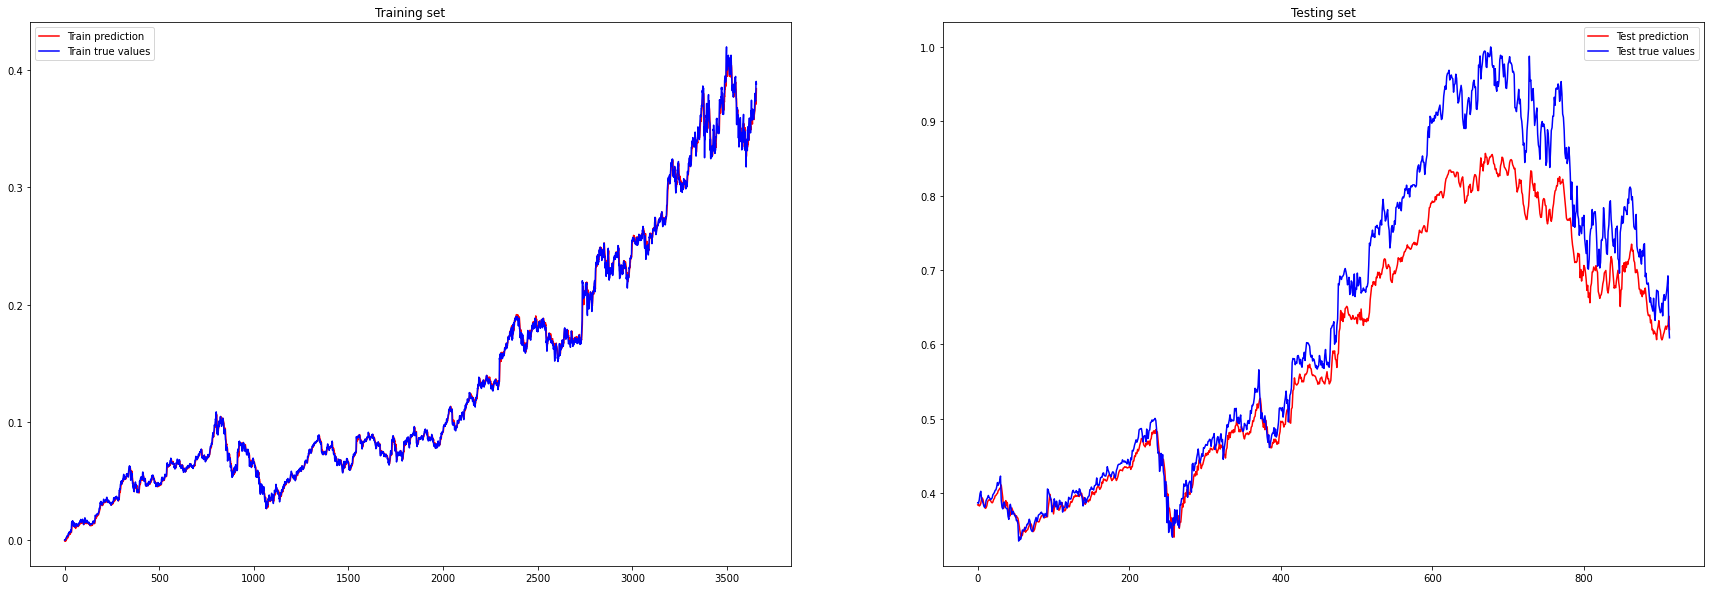

In [83]:
plot_prediction(trained_rnn)

Limitations of RNNS:

    1. Highly sensitive to recent inputs.
    2. Low sensitivity to distant inputs.
    3. Risk of vanishing and exploding gradients.
    4. RNNs are great when important characteristics are a few time-steps back.


# LSTM model

In [25]:
class LSTMnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        
        # store parameters
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        
        # RNN Layer 
        self.lstm = nn.LSTM(input_size, num_hidden, num_layers, batch_first = True)
        
        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        y, hidden = self.lstm(x)
        o = self.out(y)
        return o, hidden

In [72]:
lstm_model = LSTMnet(1, 128, 1)

In [73]:
trained_lstm, lstm_loss_history = train_model(lstm_model)

Epoch: 10 MSE: 0.005990487057715654
Epoch: 20 MSE: 0.0005765155656263232
Epoch: 30 MSE: 0.0004475847235880792
Epoch: 40 MSE: 0.00018995512800756842
Epoch: 50 MSE: 7.911697321105748e-05
Epoch: 60 MSE: 3.0546631023753434e-05
Epoch: 70 MSE: 2.463954660925083e-05
Epoch: 80 MSE: 1.990131386264693e-05
Epoch: 90 MSE: 1.7546672097523697e-05
Epoch: 100 MSE: 1.6484518710058182e-05
Epoch: 110 MSE: 1.6436251826235093e-05
Epoch: 120 MSE: 1.6303300071740523e-05
Epoch: 130 MSE: 1.624002652533818e-05
Epoch: 140 MSE: 1.618713758944068e-05
Epoch: 150 MSE: 1.6143310858751647e-05
Epoch: 160 MSE: 1.610490471648518e-05
Epoch: 170 MSE: 1.606569639989175e-05
Epoch: 180 MSE: 1.602619158802554e-05
Epoch: 190 MSE: 1.5985595382517204e-05


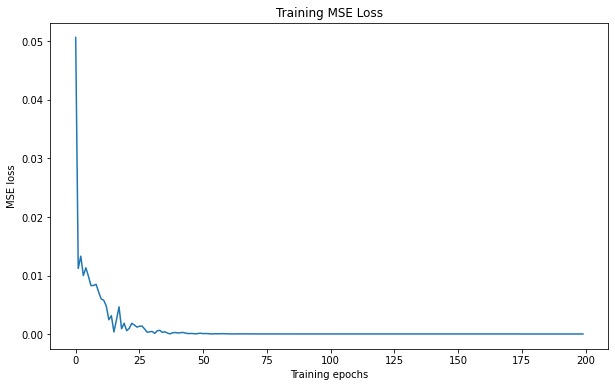

In [74]:
plot_loss(lstm_loss_history)

Train Score: 0.59 RMSE
Test Score: 3.91 RMSE


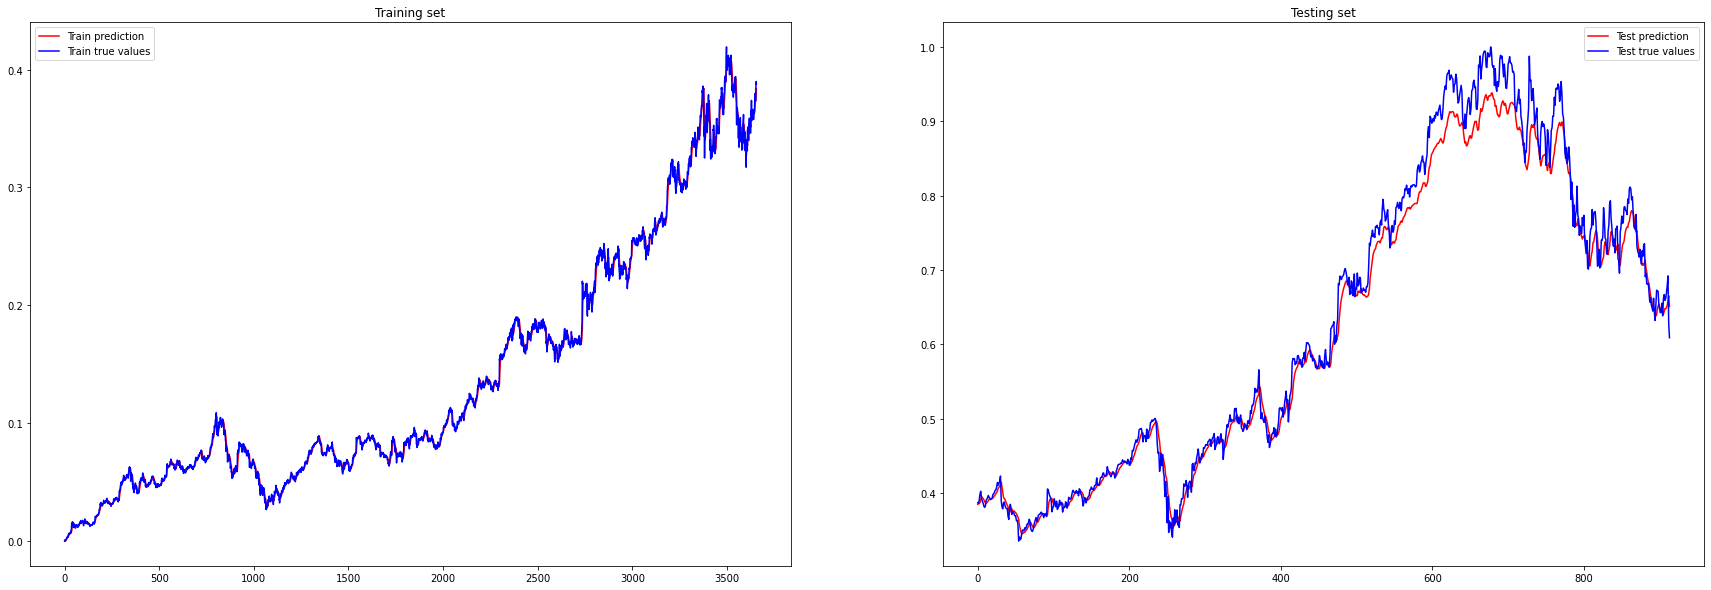

In [75]:
plot_prediction(trained_lstm)

# GRU Model

In [84]:
class GRUnet(nn.Module):
    def __init__(self, input_size, num_hidden, num_layers):
        super().__init__()
        
        # store parameters
        self.input_size = input_size
        self.num_hidden = num_hidden
        self.num_layers = num_layers
        
        # RNN Layer 
        self.gru = nn.GRU(input_size, num_hidden, num_layers, batch_first = True)
        
        # linear layer for output
        self.out = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        y, hidden = self.gru(x)
        o = self.out(y)
        return o, hidden

In [93]:
grumodel = GRUnet(1, 128, 1)

In [94]:
trained_gru, gru_loss_history = train_model(grumodel)

Epoch: 10 MSE: 0.010925889946520329
Epoch: 20 MSE: 0.004326865542680025
Epoch: 30 MSE: 0.0006406859611161053
Epoch: 40 MSE: 0.00019963072554674
Epoch: 50 MSE: 3.626430770964362e-05
Epoch: 60 MSE: 3.639683563960716e-05
Epoch: 70 MSE: 2.568819581938442e-05
Epoch: 80 MSE: 1.893264015961904e-05
Epoch: 90 MSE: 1.652550599828828e-05
Epoch: 100 MSE: 1.4703457964060362e-05
Epoch: 110 MSE: 1.4337980246637017e-05
Epoch: 120 MSE: 1.4209726032277104e-05
Epoch: 130 MSE: 1.408373918820871e-05
Epoch: 140 MSE: 1.396183688484598e-05
Epoch: 150 MSE: 1.3847690752299968e-05
Epoch: 160 MSE: 1.374071234749863e-05
Epoch: 170 MSE: 1.3639036296808627e-05
Epoch: 180 MSE: 1.3542035958380438e-05
Epoch: 190 MSE: 1.3449470316118095e-05


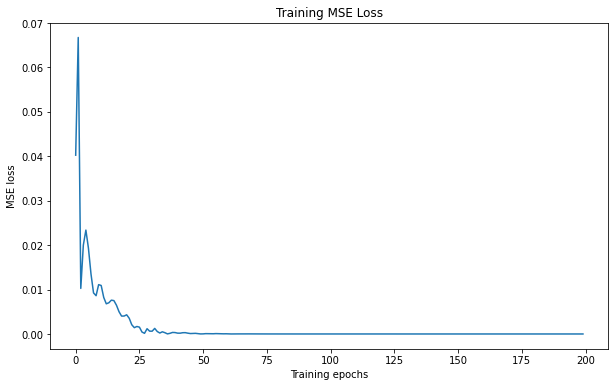

In [95]:
plot_loss(gru_loss_history)

Train Score: 0.54 RMSE
Test Score: 3.50 RMSE


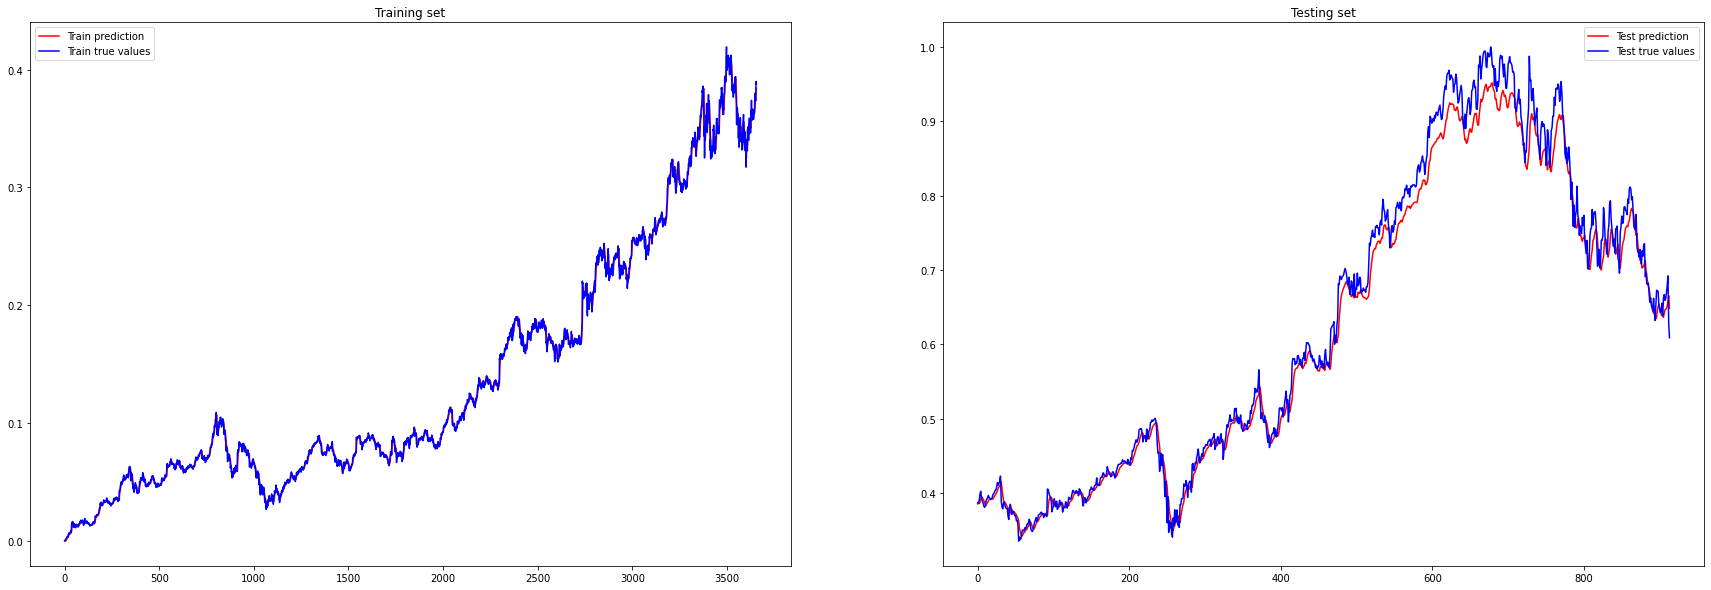

In [96]:
plot_prediction(trained_gru)

# Optimise model structure

In [97]:
input_size = 1 
hidden_size = [32, 64, 128]
num_layers = [1, 2, 3]

## RNN model

Current RNN model: 
Number of layers: 1, Hidden sizes: 32
Train Score: 0.46 RMSE
Test Score: 5.40 RMSE

Current RNN model: 
Number of layers: 2, Hidden sizes: 32
Train Score: 0.52 RMSE
Test Score: 13.07 RMSE

Current RNN model: 
Number of layers: 3, Hidden sizes: 32
Train Score: 0.67 RMSE
Test Score: 19.33 RMSE

Current RNN model: 
Number of layers: 1, Hidden sizes: 64
Train Score: 0.51 RMSE
Test Score: 6.82 RMSE

Current RNN model: 
Number of layers: 2, Hidden sizes: 64
Train Score: 0.60 RMSE
Test Score: 17.29 RMSE

Current RNN model: 
Number of layers: 3, Hidden sizes: 64
Train Score: 0.92 RMSE
Test Score: 35.21 RMSE

Current RNN model: 
Number of layers: 1, Hidden sizes: 128
Train Score: 0.85 RMSE
Test Score: 25.88 RMSE

Current RNN model: 
Number of layers: 2, Hidden sizes: 128
Train Score: 1.15 RMSE
Test Score: 32.22 RMSE

Current RNN model: 
Number of layers: 3, Hidden sizes: 128
Train Score: 15.40 RMSE
Test Score: 79.78 RMSE



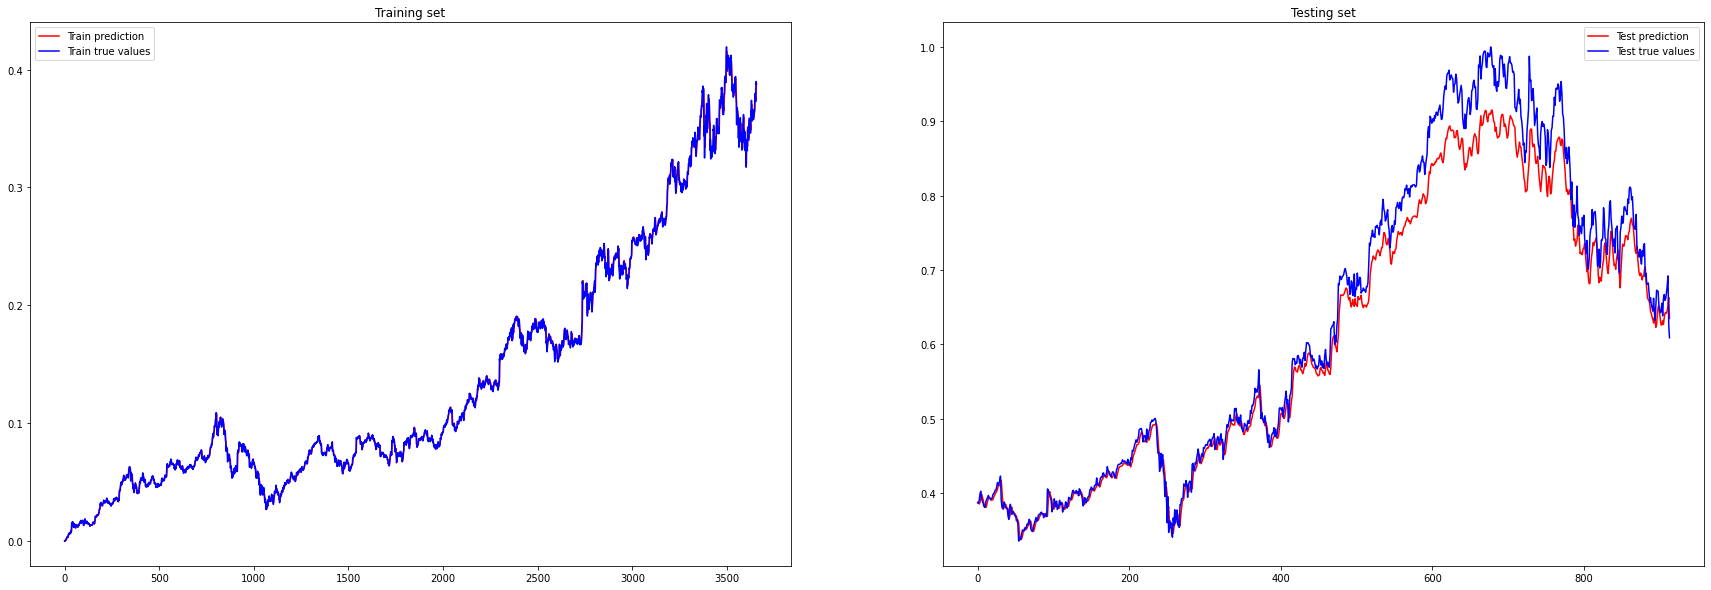

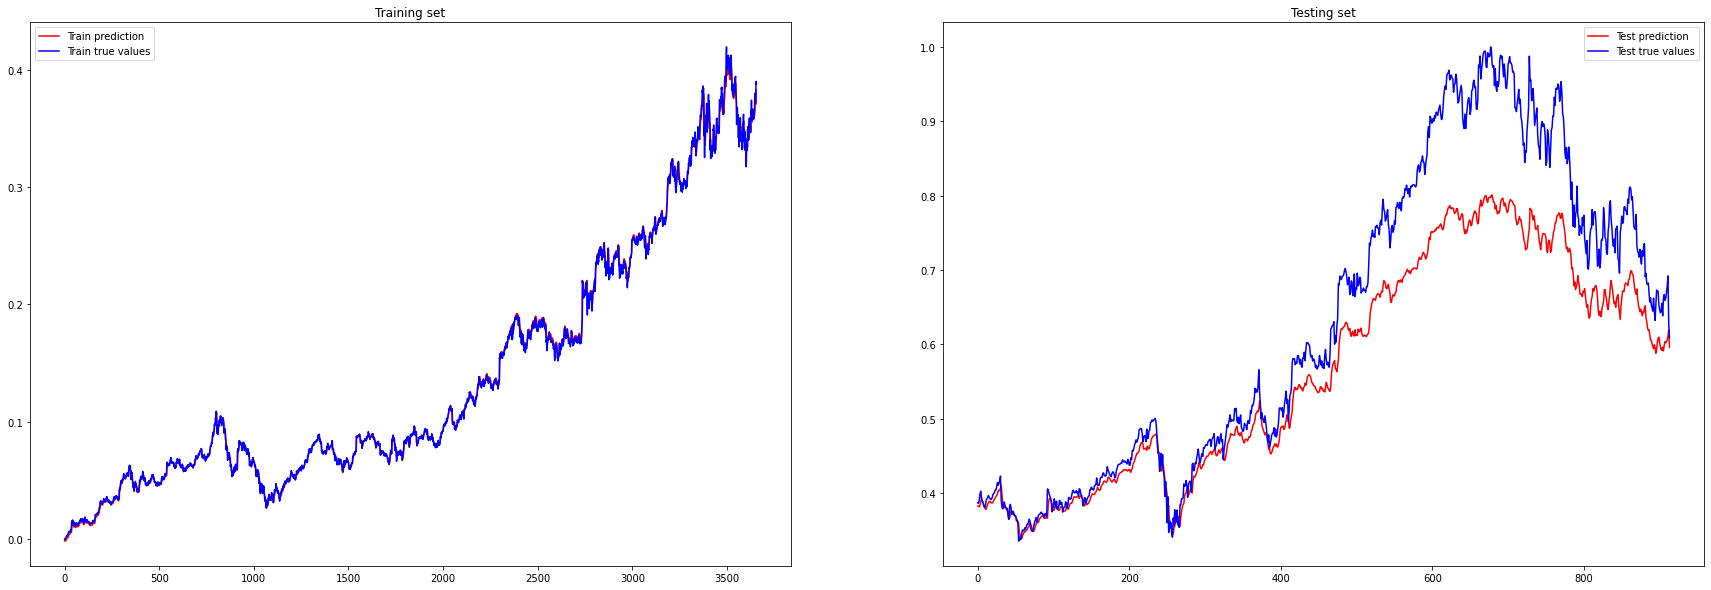

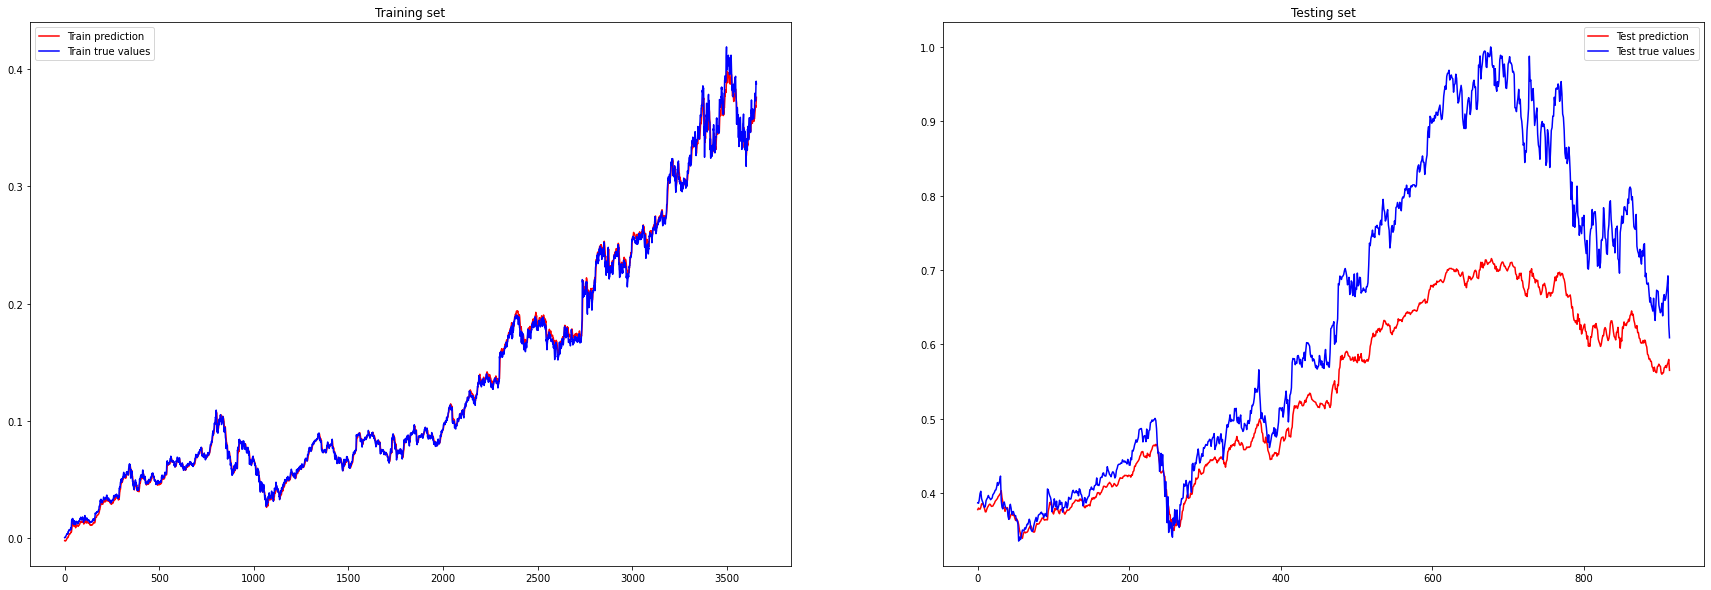

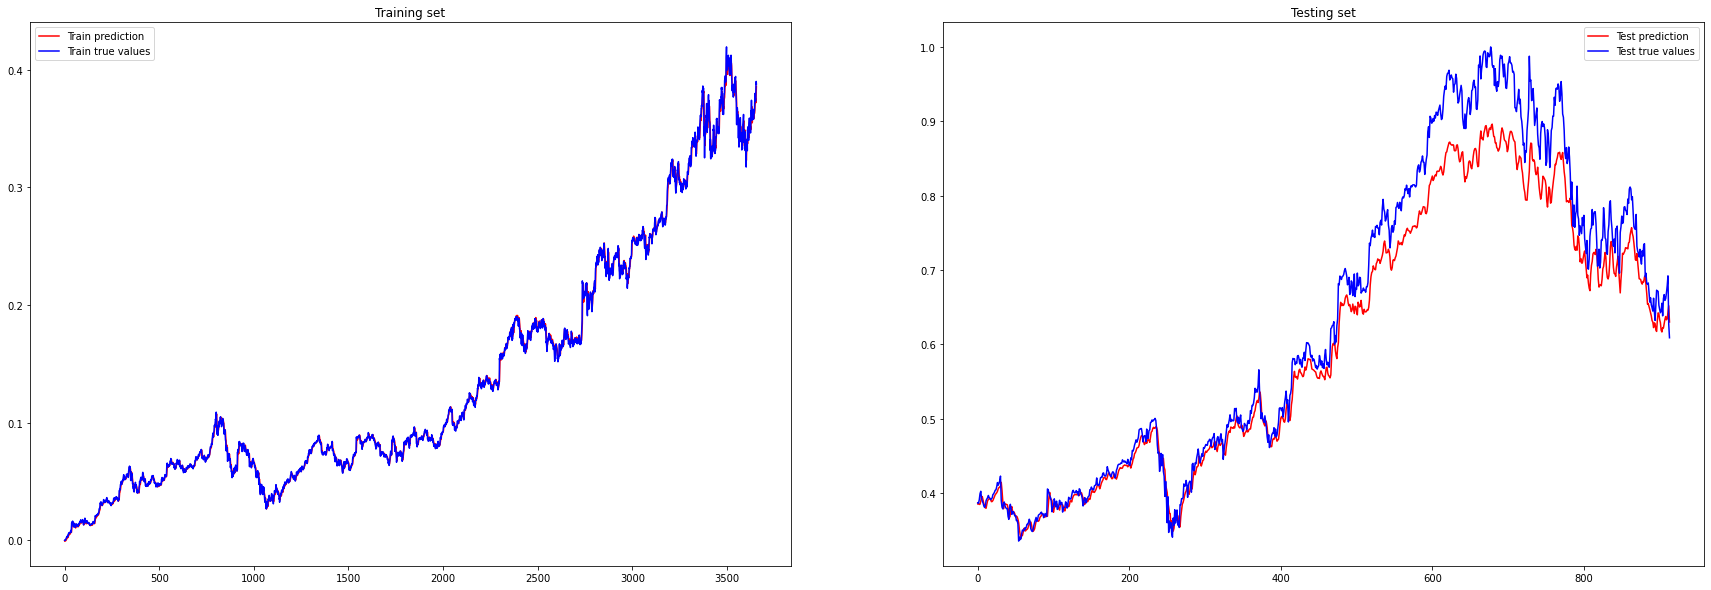

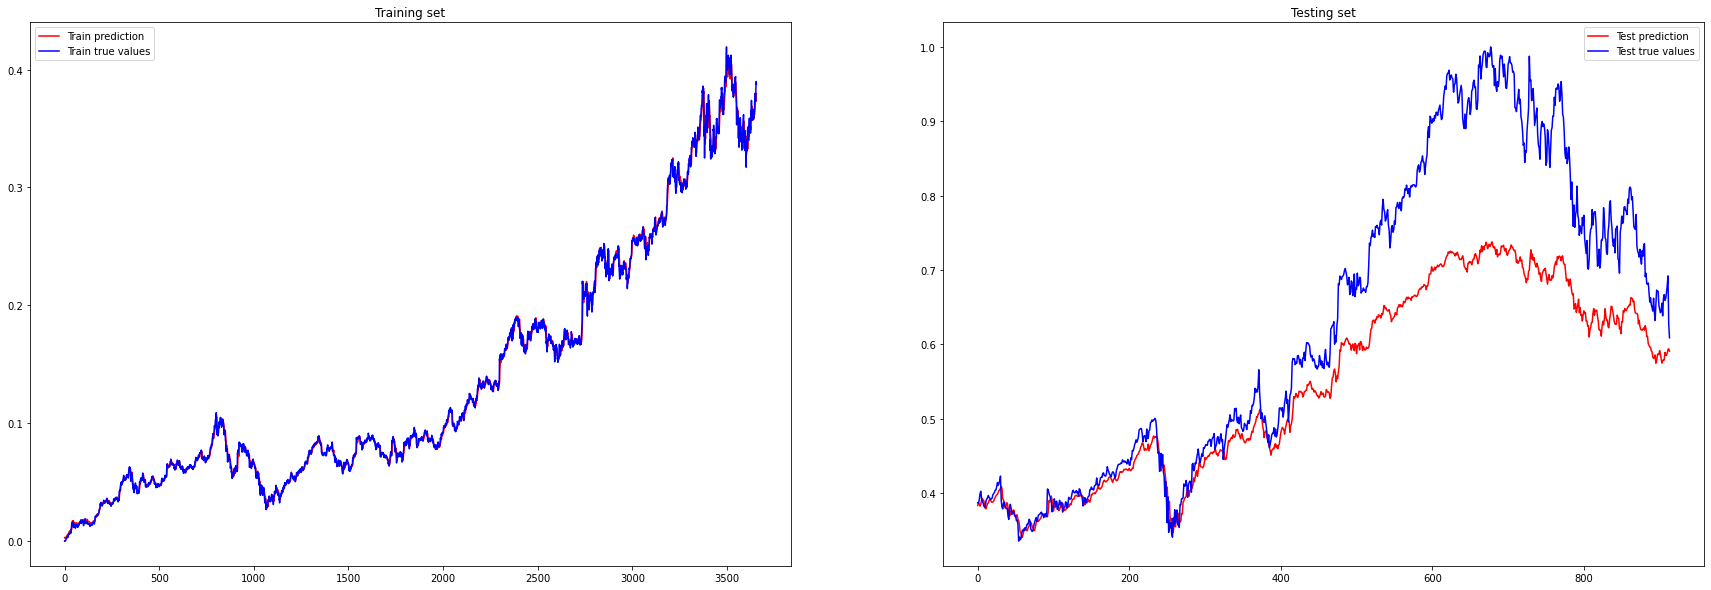

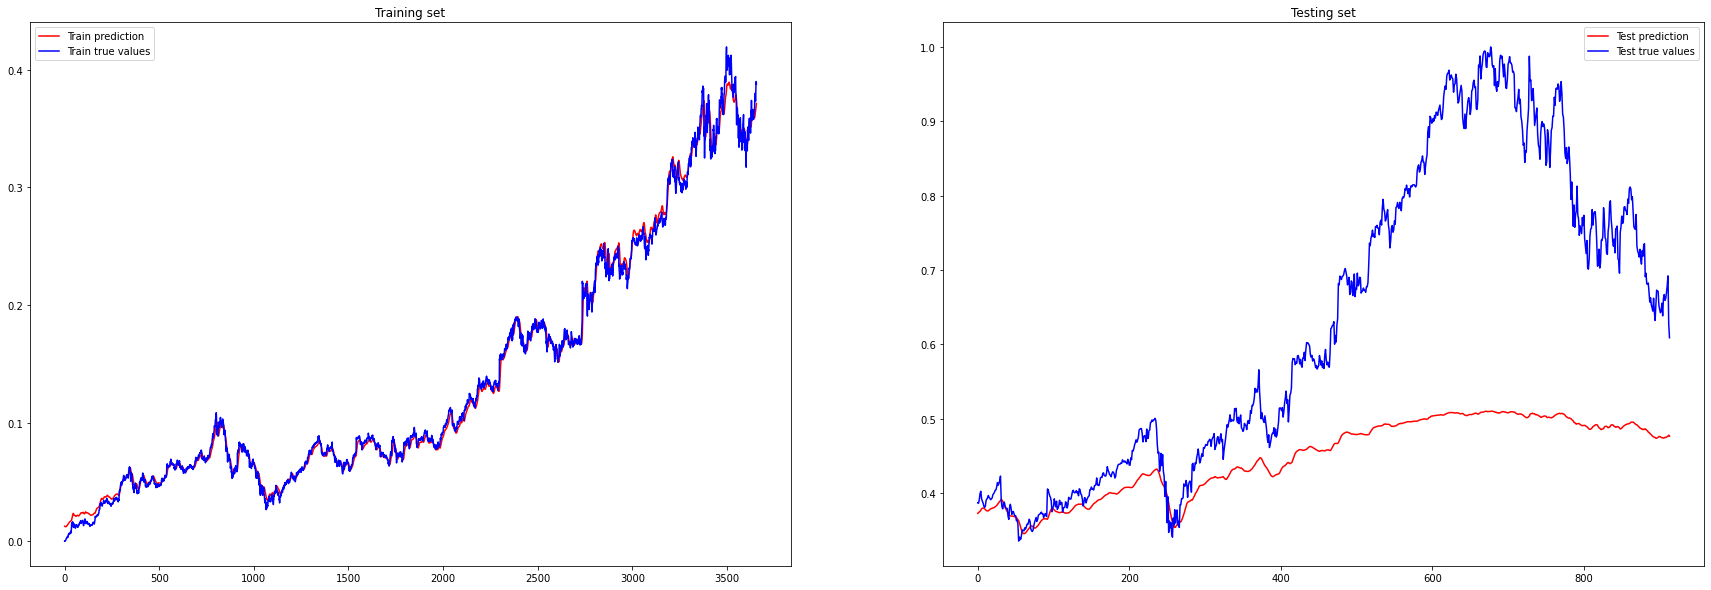

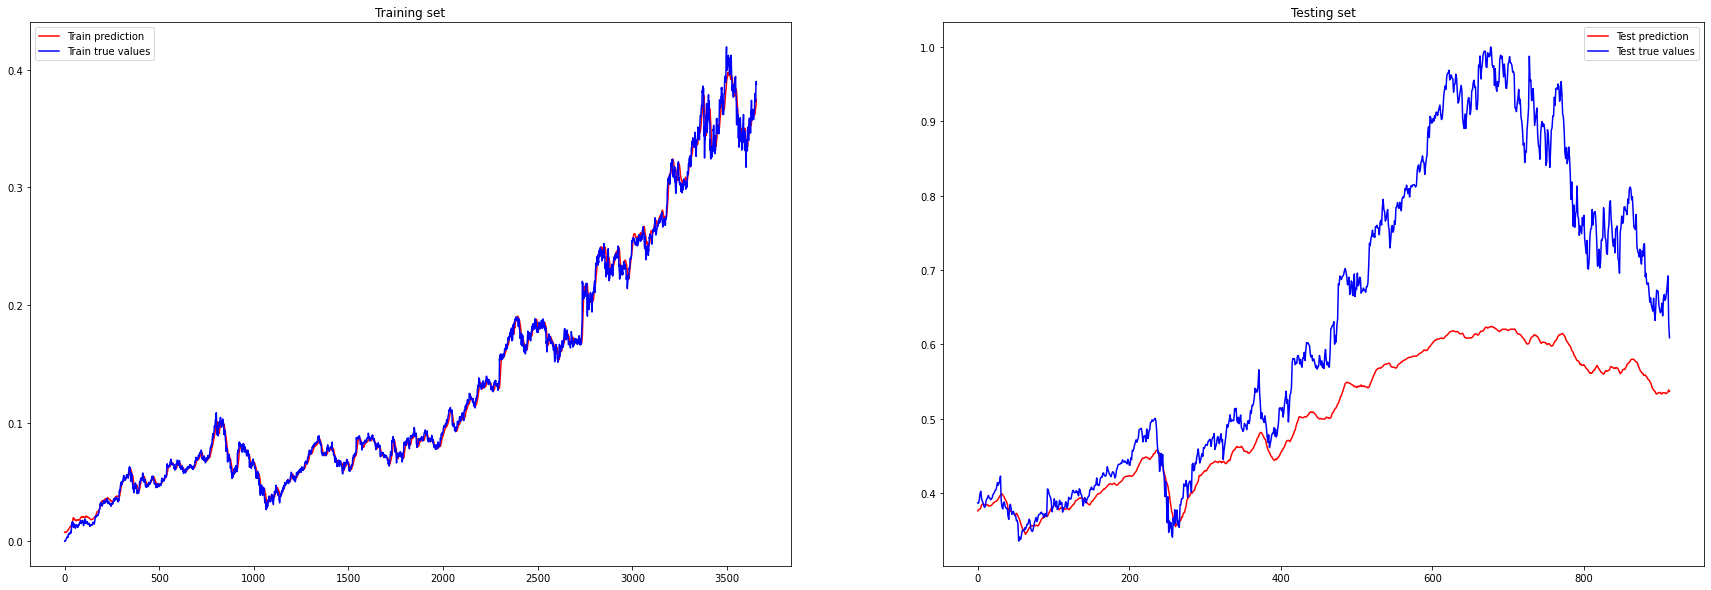

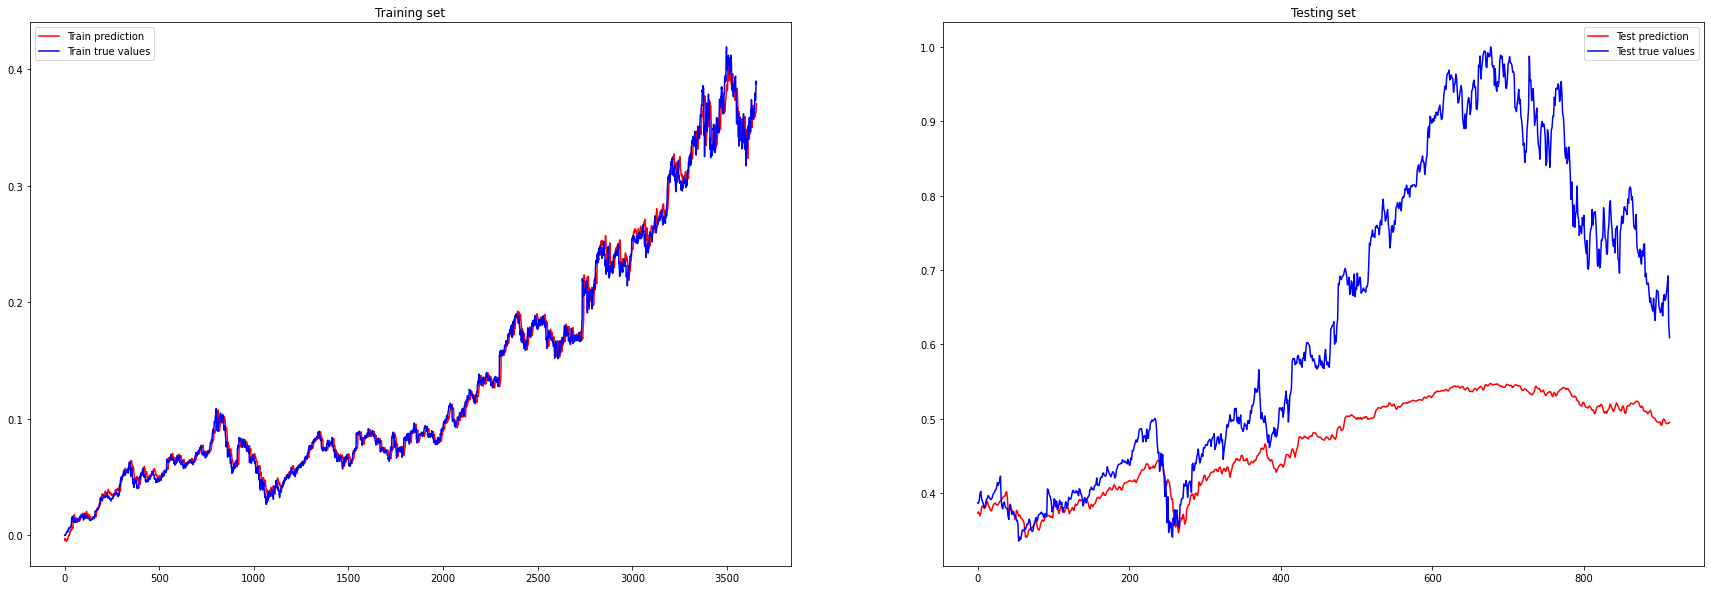

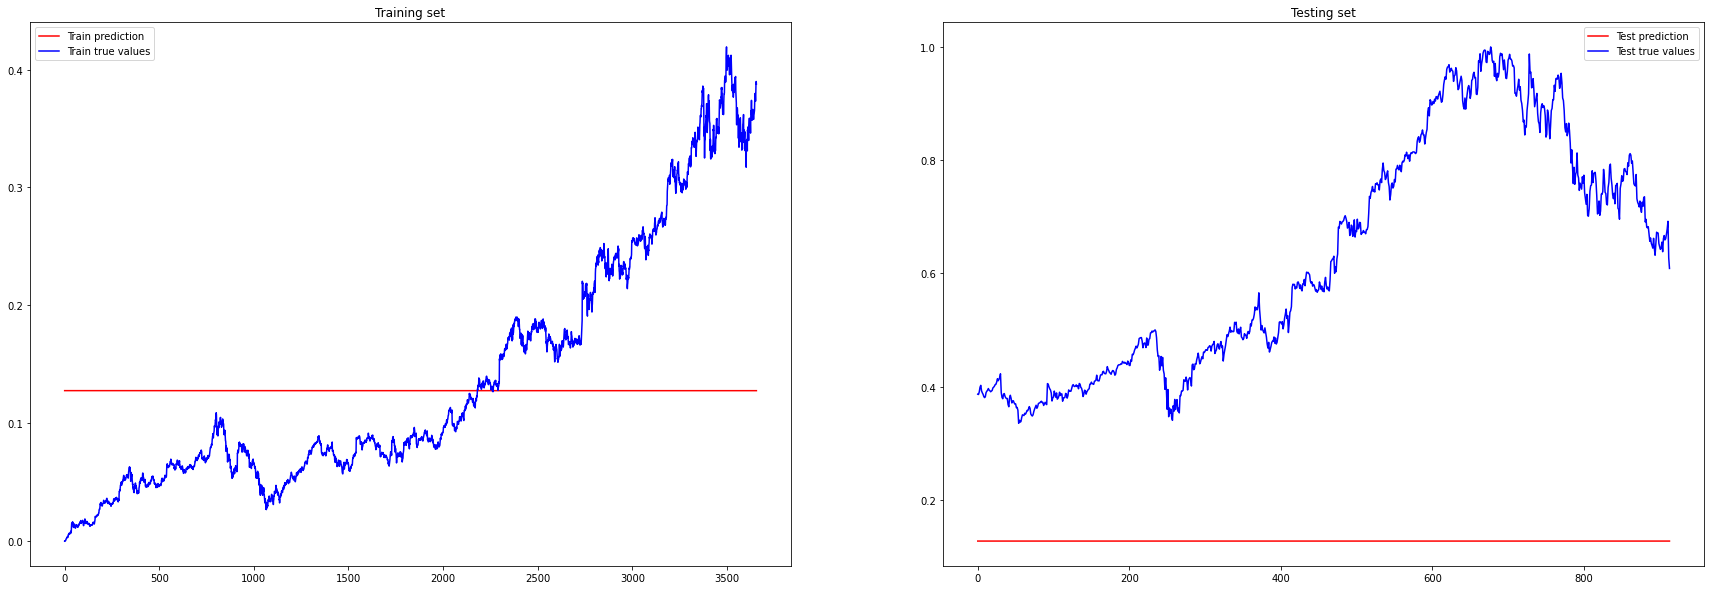

In [104]:
for hs in hidden_size:
    for nl in num_layers:
        print("Current RNN model: ")
        print("Number of layers: {}, Hidden sizes: {}".format(nl, hs))
        test_rnn = RNNnet(input_size, hs, nl)   
        trained_rnn_test, test_rnn_loss = train_model(test_rnn, verbose=0)
        plot_prediction(trained_rnn_test)
        print()   

## LSTM model

Current LSTM model: 
Number of layers: 1, Hidden sizes: 32
Train Score: 0.59 RMSE
Test Score: 12.14 RMSE

Current LSTM model: 
Number of layers: 2, Hidden sizes: 32
Train Score: 0.76 RMSE
Test Score: 25.50 RMSE

Current LSTM model: 
Number of layers: 3, Hidden sizes: 32
Train Score: 0.83 RMSE
Test Score: 20.93 RMSE

Current LSTM model: 
Number of layers: 1, Hidden sizes: 64
Train Score: 0.59 RMSE
Test Score: 5.91 RMSE

Current LSTM model: 
Number of layers: 2, Hidden sizes: 64
Train Score: 0.73 RMSE
Test Score: 20.33 RMSE

Current LSTM model: 
Number of layers: 3, Hidden sizes: 64
Train Score: 0.86 RMSE
Test Score: 30.25 RMSE

Current LSTM model: 
Number of layers: 1, Hidden sizes: 128
Train Score: 0.58 RMSE
Test Score: 5.40 RMSE

Current LSTM model: 
Number of layers: 2, Hidden sizes: 128
Train Score: 0.74 RMSE
Test Score: 22.11 RMSE

Current LSTM model: 
Number of layers: 3, Hidden sizes: 128
Train Score: 0.85 RMSE
Test Score: 26.07 RMSE



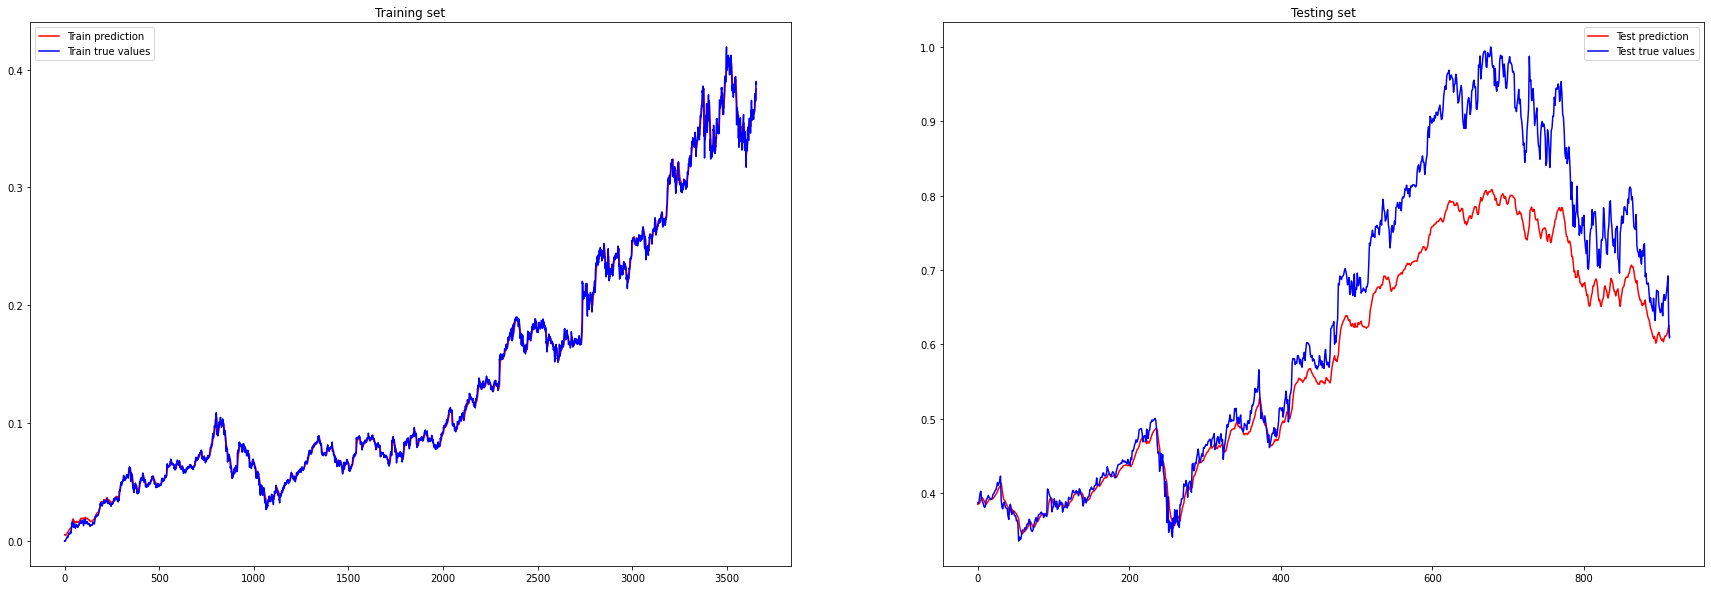

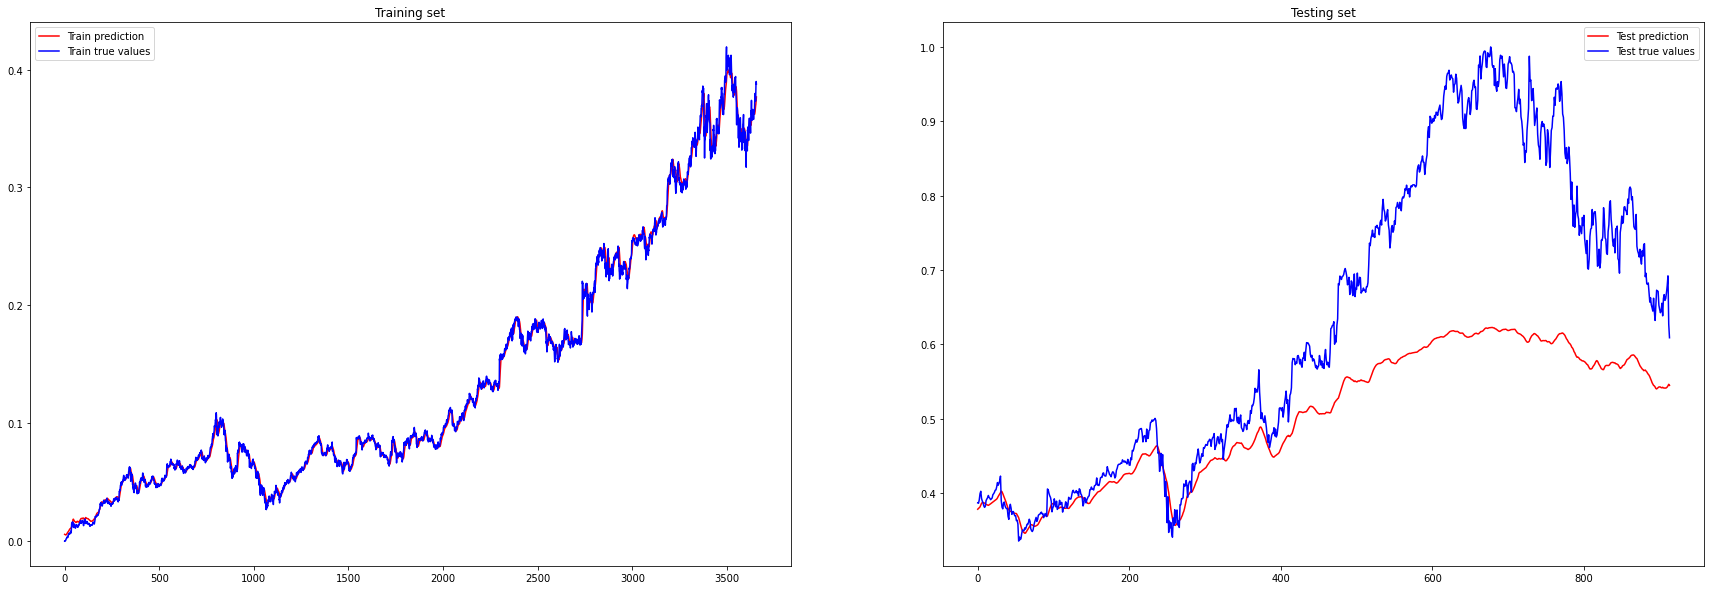

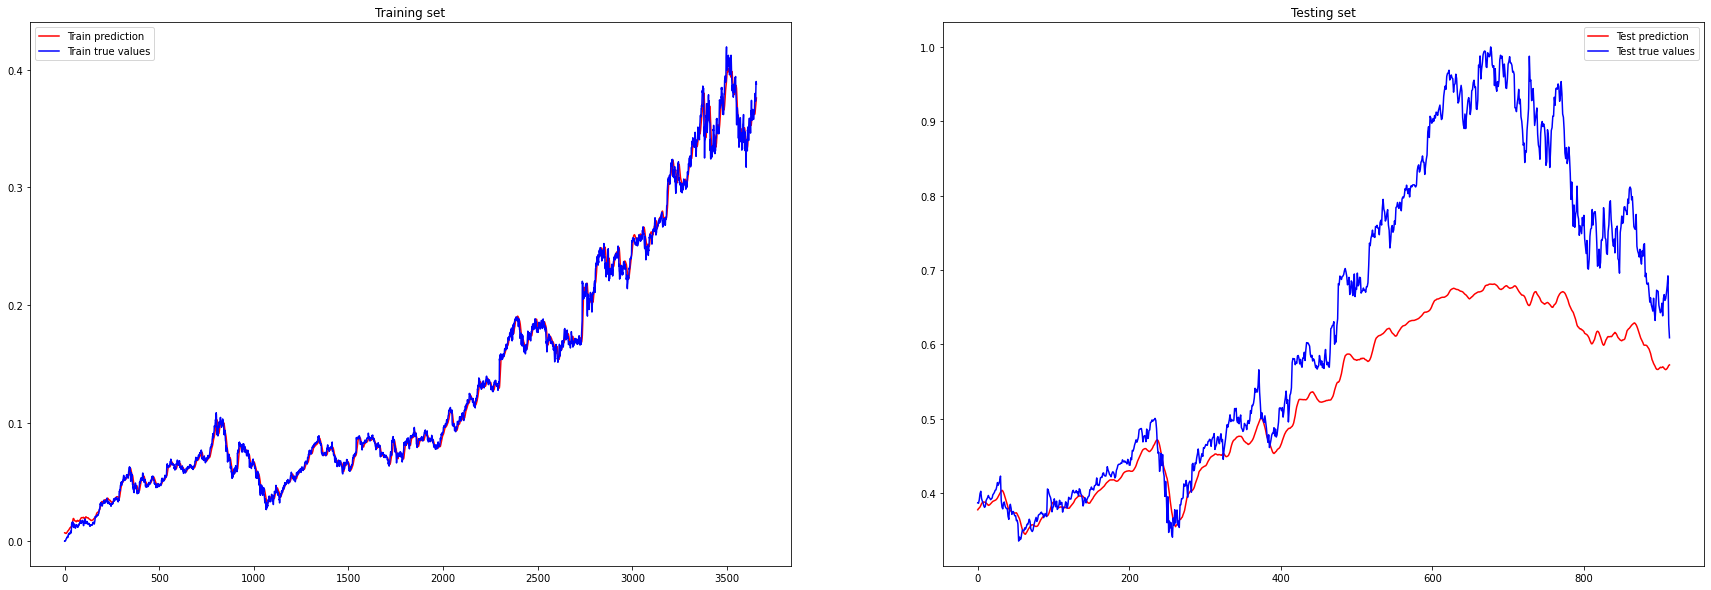

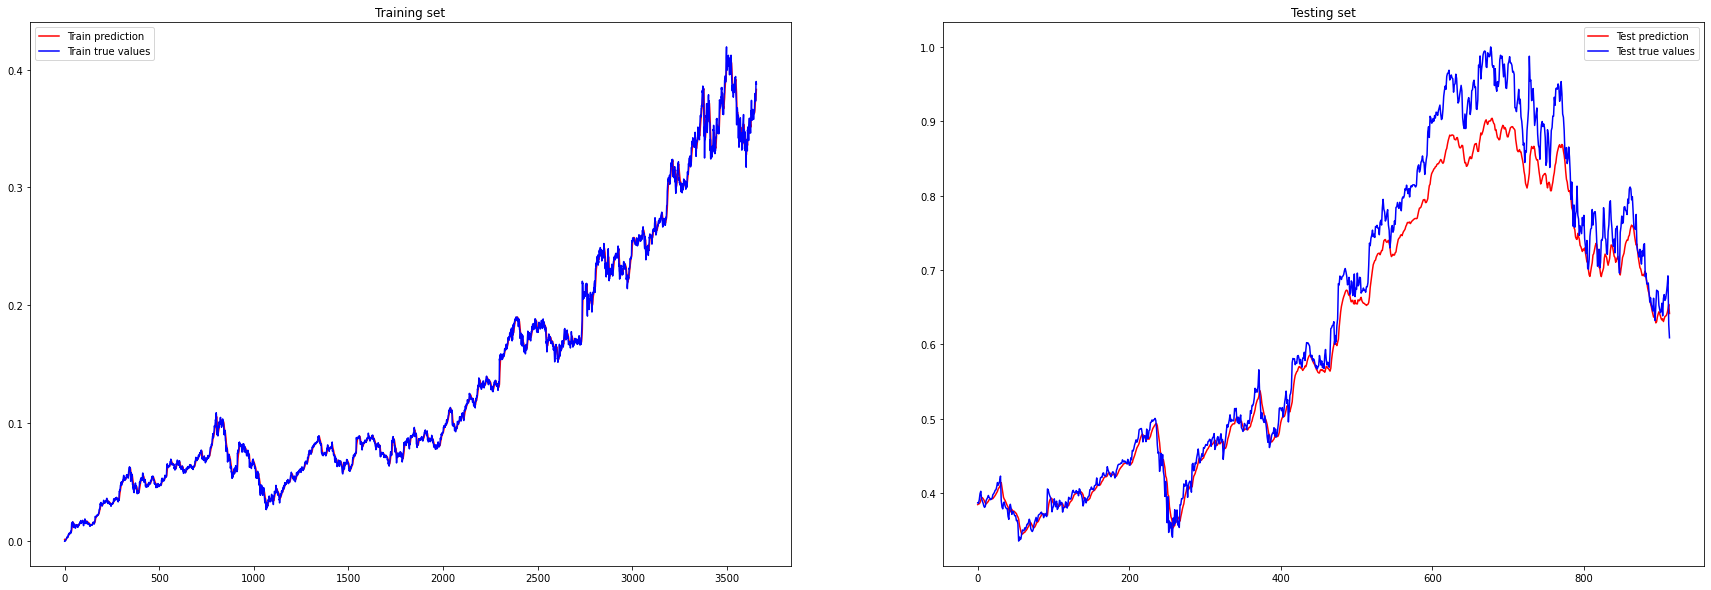

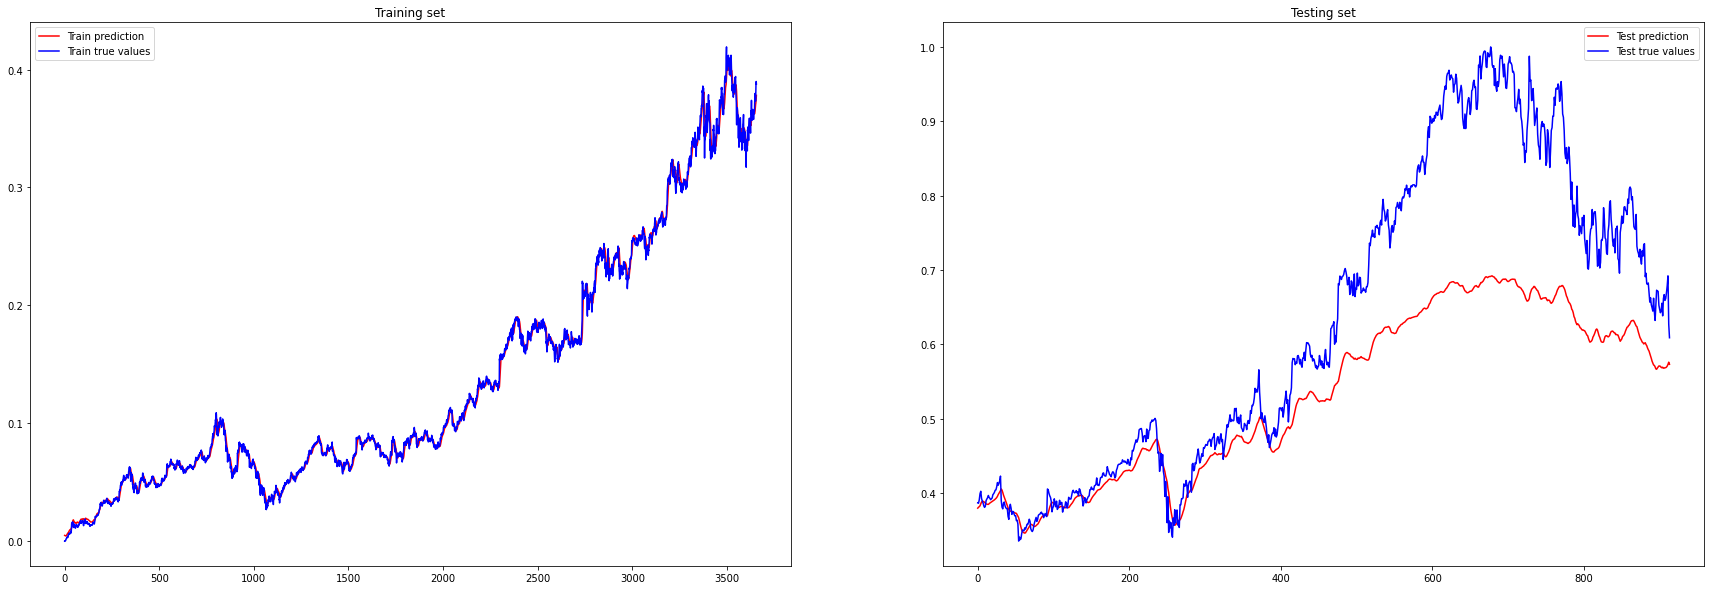

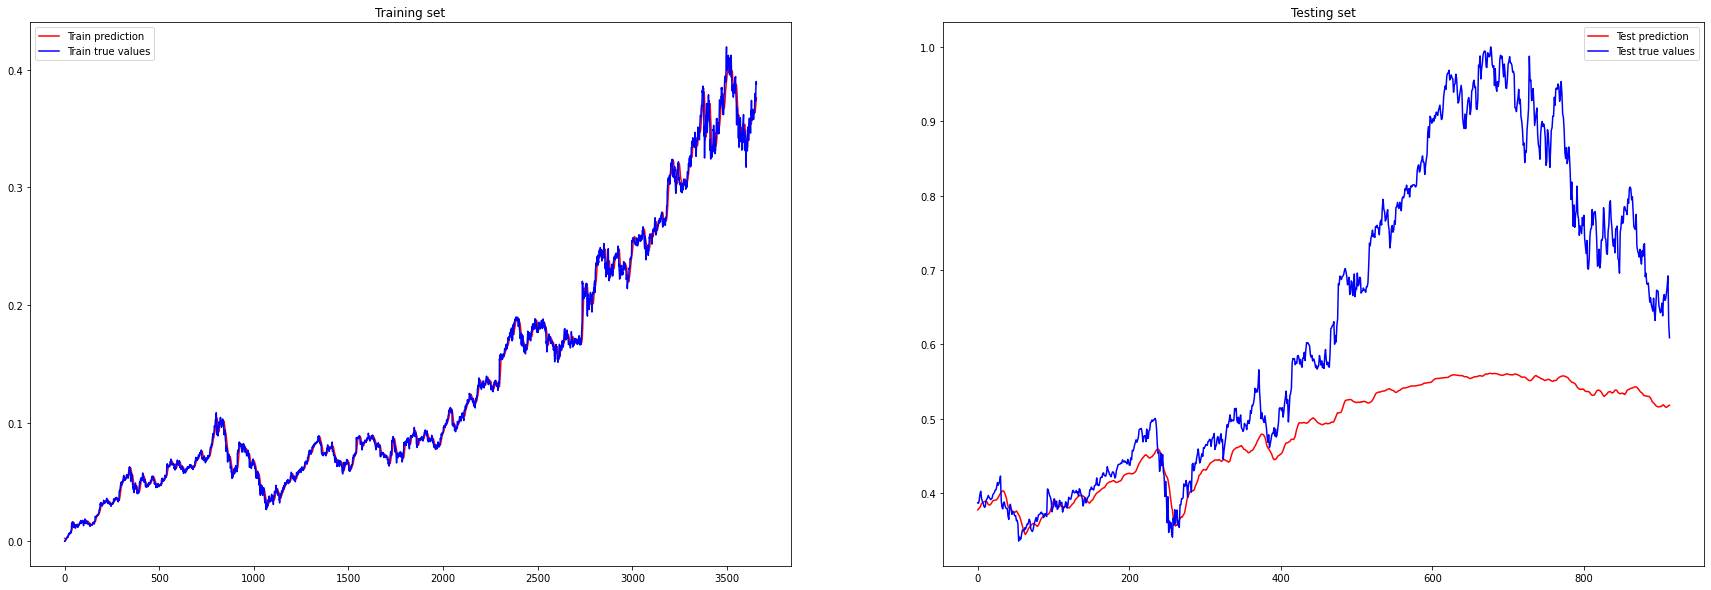

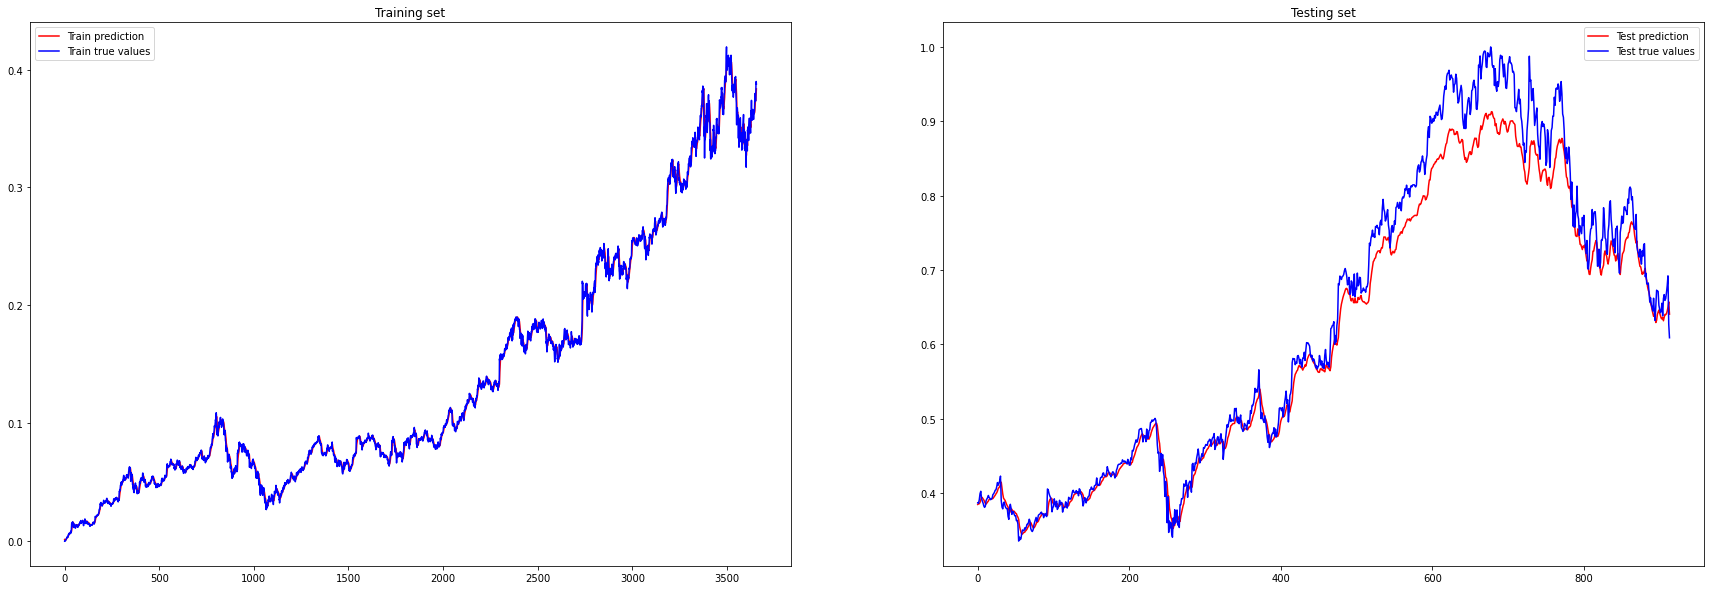

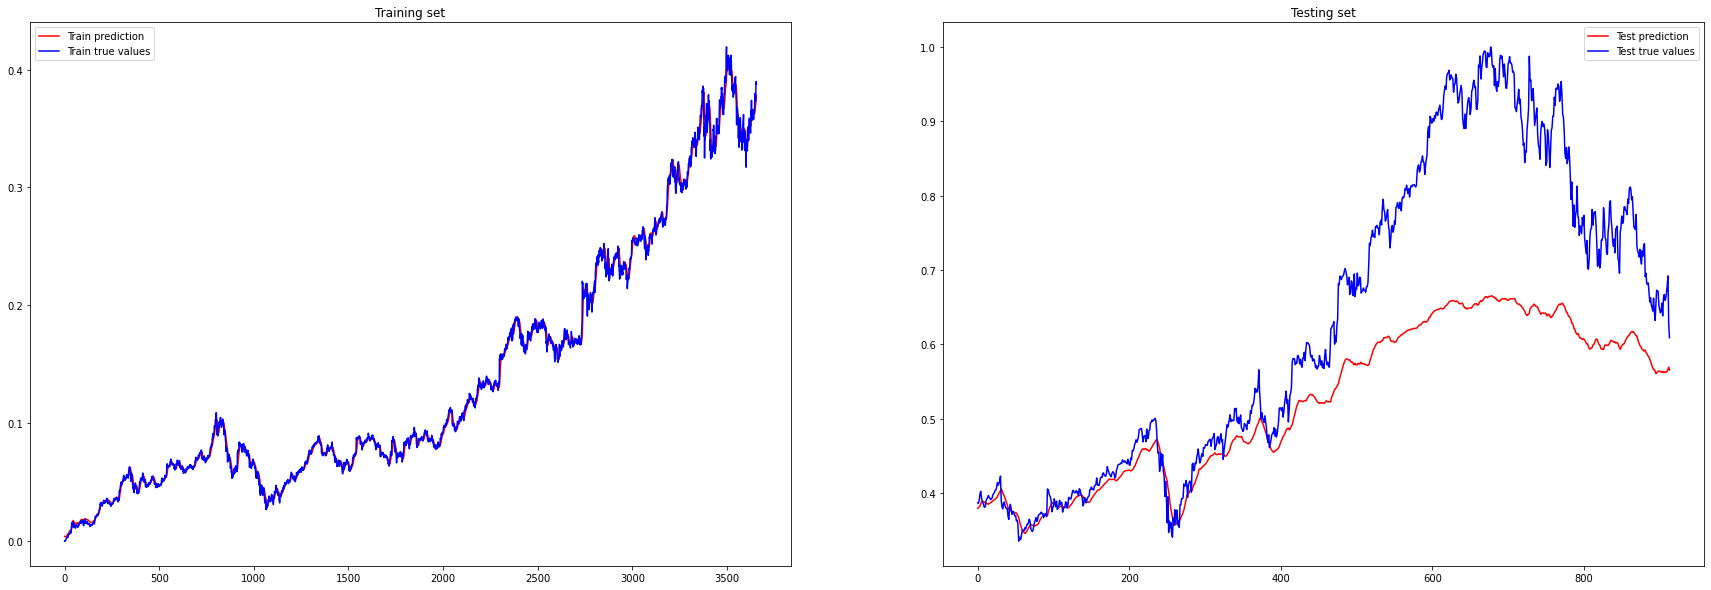

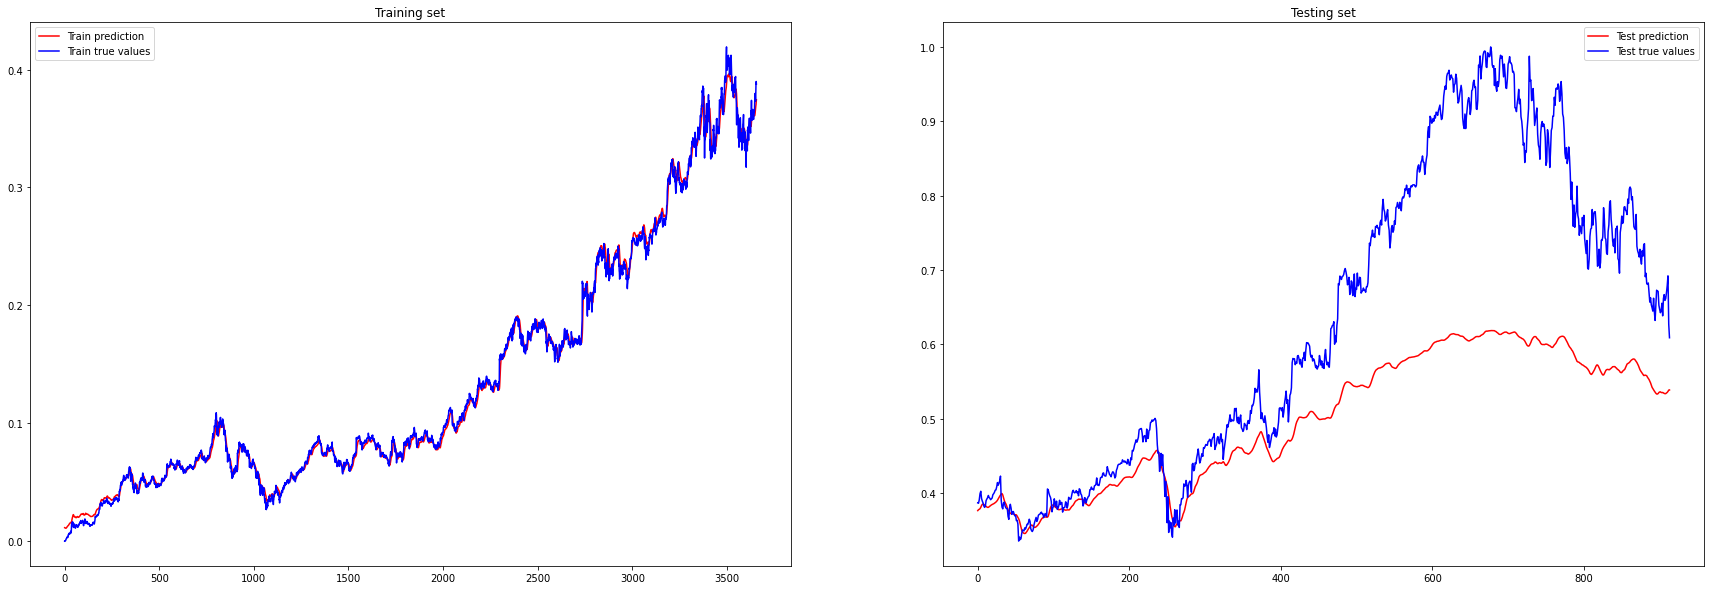

In [105]:
for hs in hidden_size:
    for nl in num_layers:
        print("Current LSTM model: ")
        print("Number of layers: {}, Hidden sizes: {}".format(nl, hs))
        test_lstm = LSTMnet(input_size, hs, nl)   
        trained_lstm_test, test_lstm_loss = train_model(test_lstm, verbose=0)
        plot_prediction(trained_lstm_test)
        print()
        

## GRU model

Current gru model: 
Number of layers: 1, Hidden sizes: 32
Train Score: 0.55 RMSE
Test Score: 4.98 RMSE

Current gru model: 
Number of layers: 2, Hidden sizes: 32
Train Score: 0.62 RMSE
Test Score: 6.71 RMSE

Current gru model: 
Number of layers: 3, Hidden sizes: 32
Train Score: 0.71 RMSE
Test Score: 16.80 RMSE

Current gru model: 
Number of layers: 1, Hidden sizes: 64
Train Score: 0.54 RMSE
Test Score: 3.78 RMSE

Current gru model: 
Number of layers: 2, Hidden sizes: 64
Train Score: 0.65 RMSE
Test Score: 6.49 RMSE

Current gru model: 
Number of layers: 3, Hidden sizes: 64
Train Score: 0.71 RMSE
Test Score: 11.69 RMSE

Current gru model: 
Number of layers: 1, Hidden sizes: 128
Train Score: 0.52 RMSE
Test Score: 3.05 RMSE

Current gru model: 
Number of layers: 2, Hidden sizes: 128
Train Score: 0.64 RMSE
Test Score: 6.31 RMSE

Current gru model: 
Number of layers: 3, Hidden sizes: 128
Train Score: 0.87 RMSE
Test Score: 17.89 RMSE



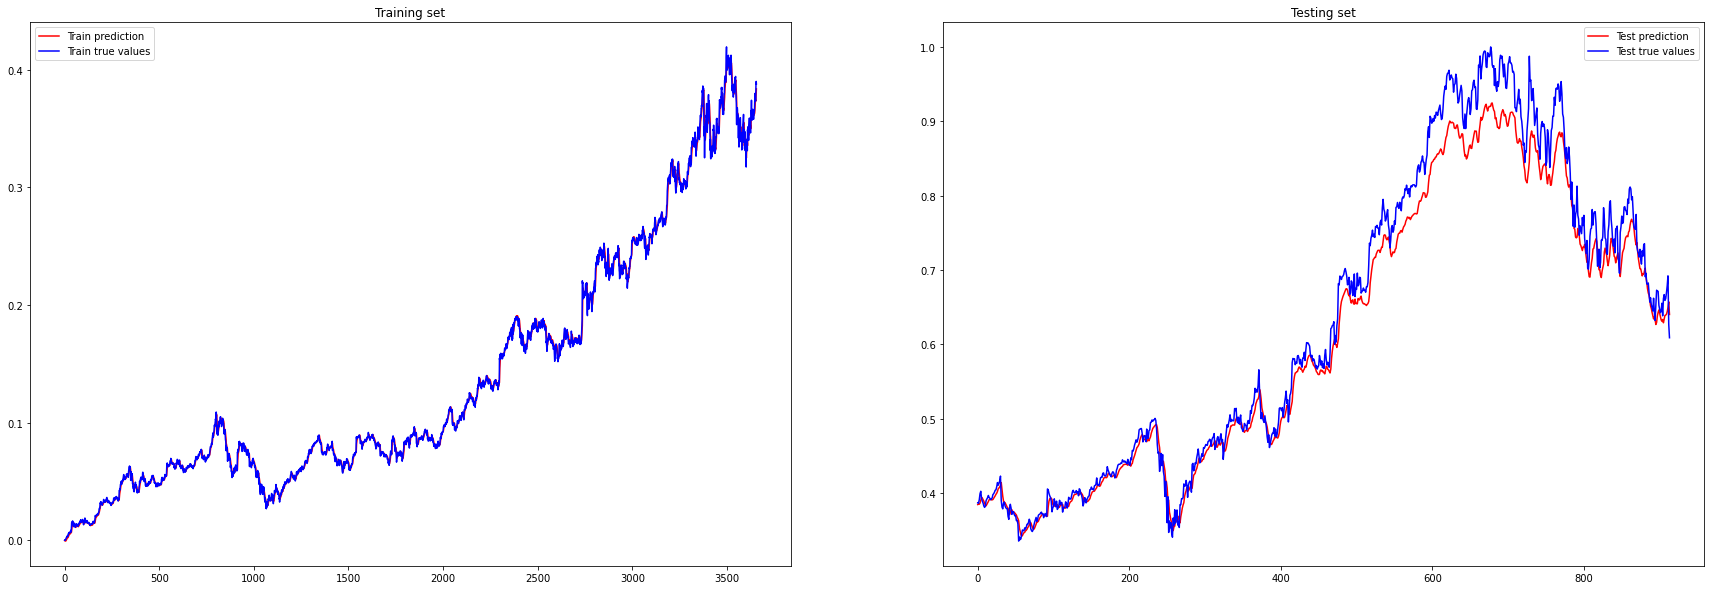

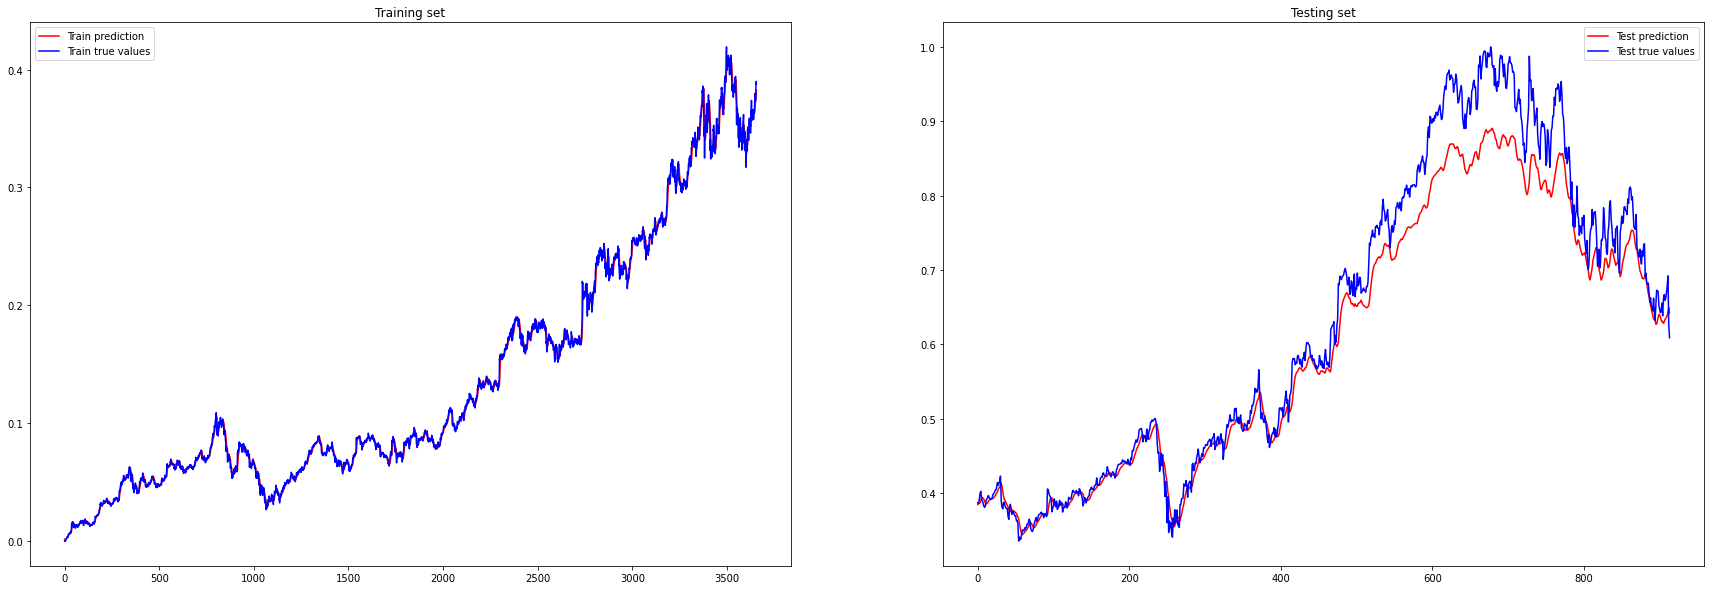

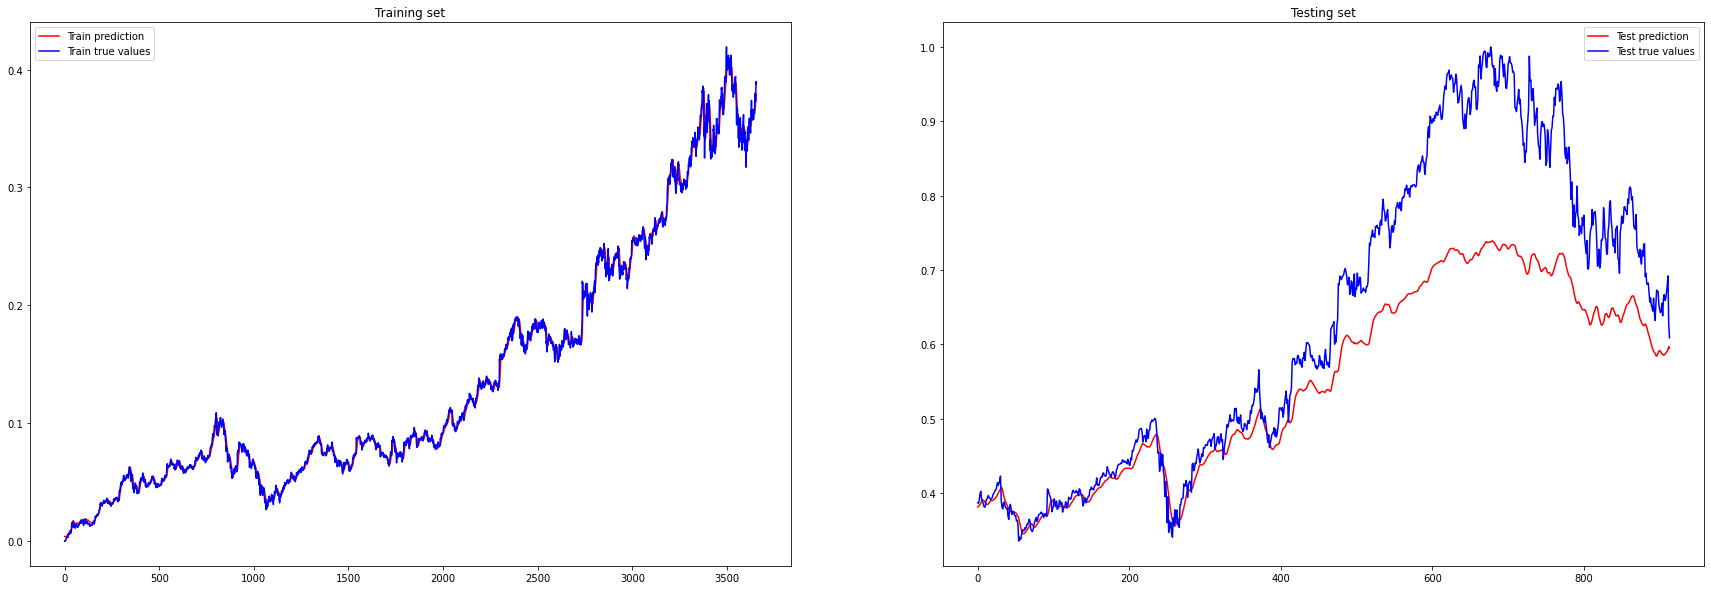

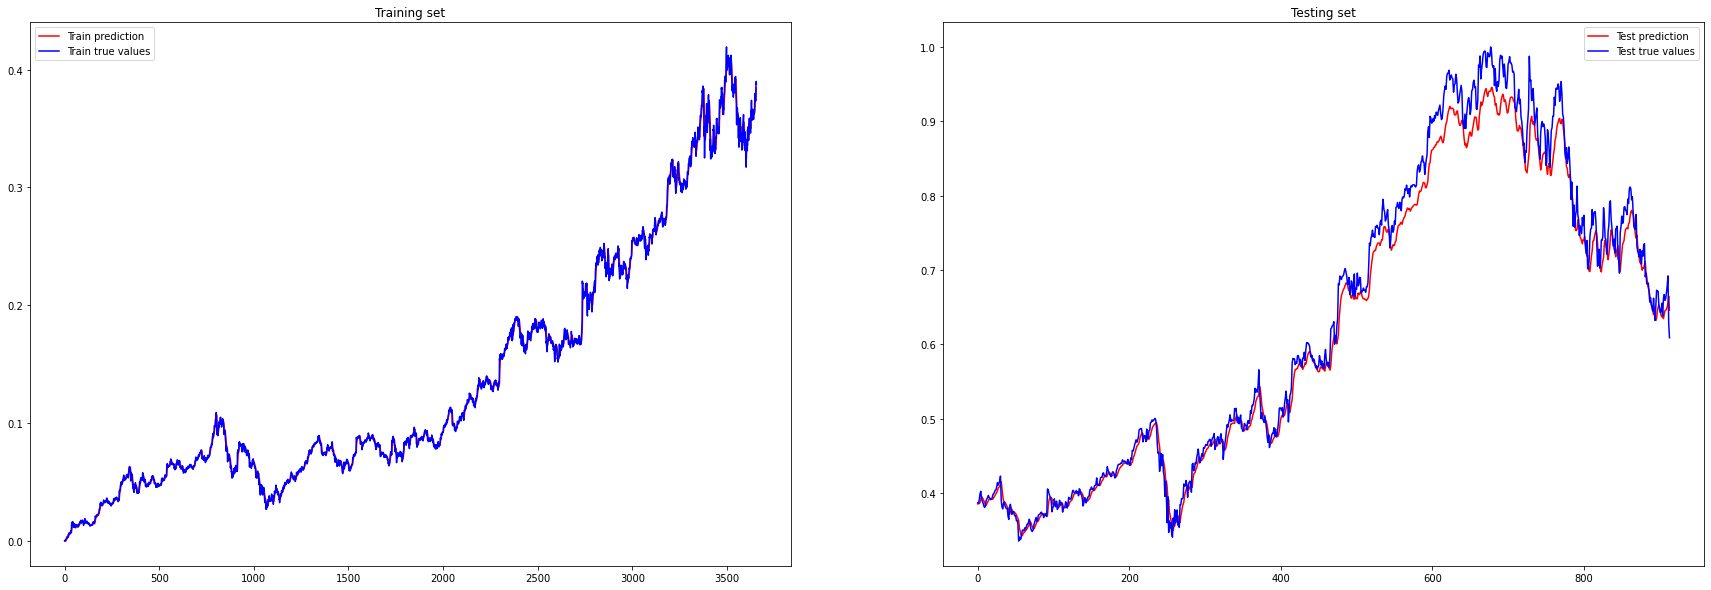

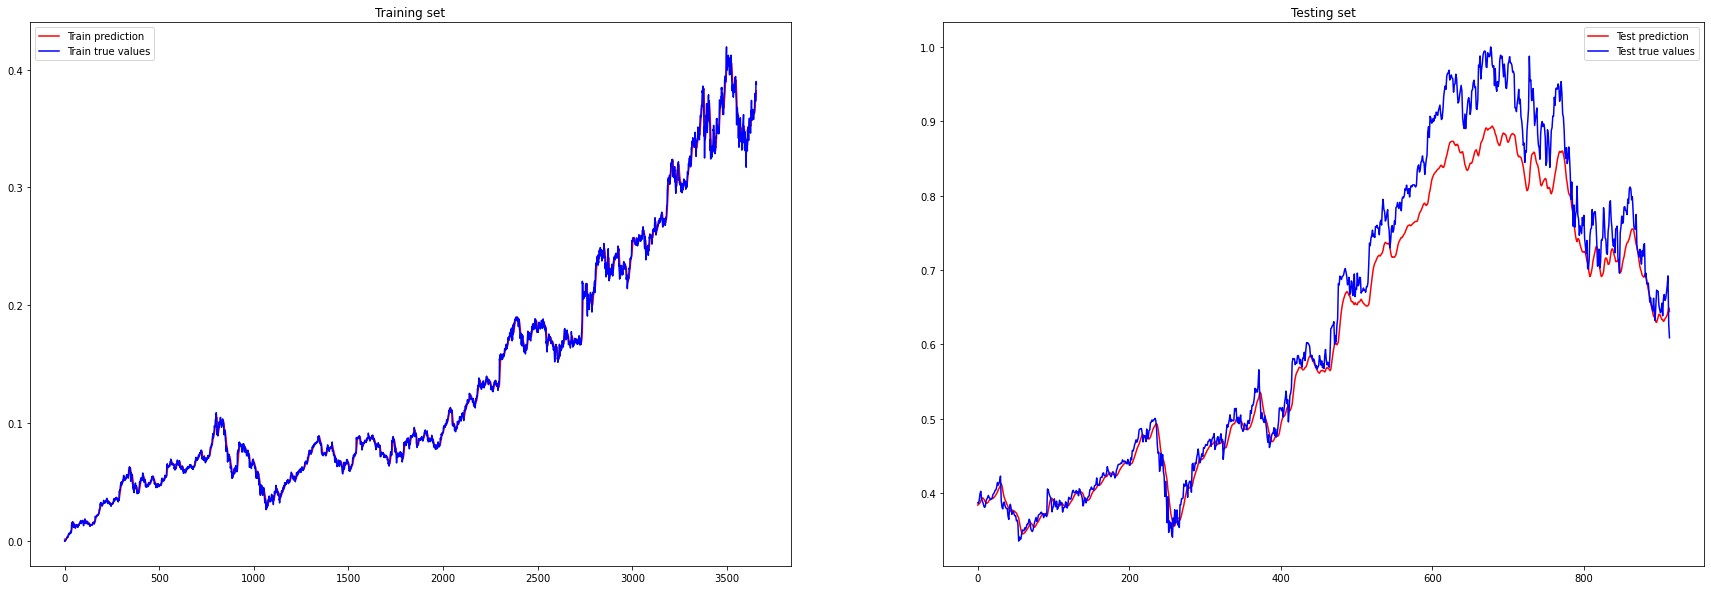

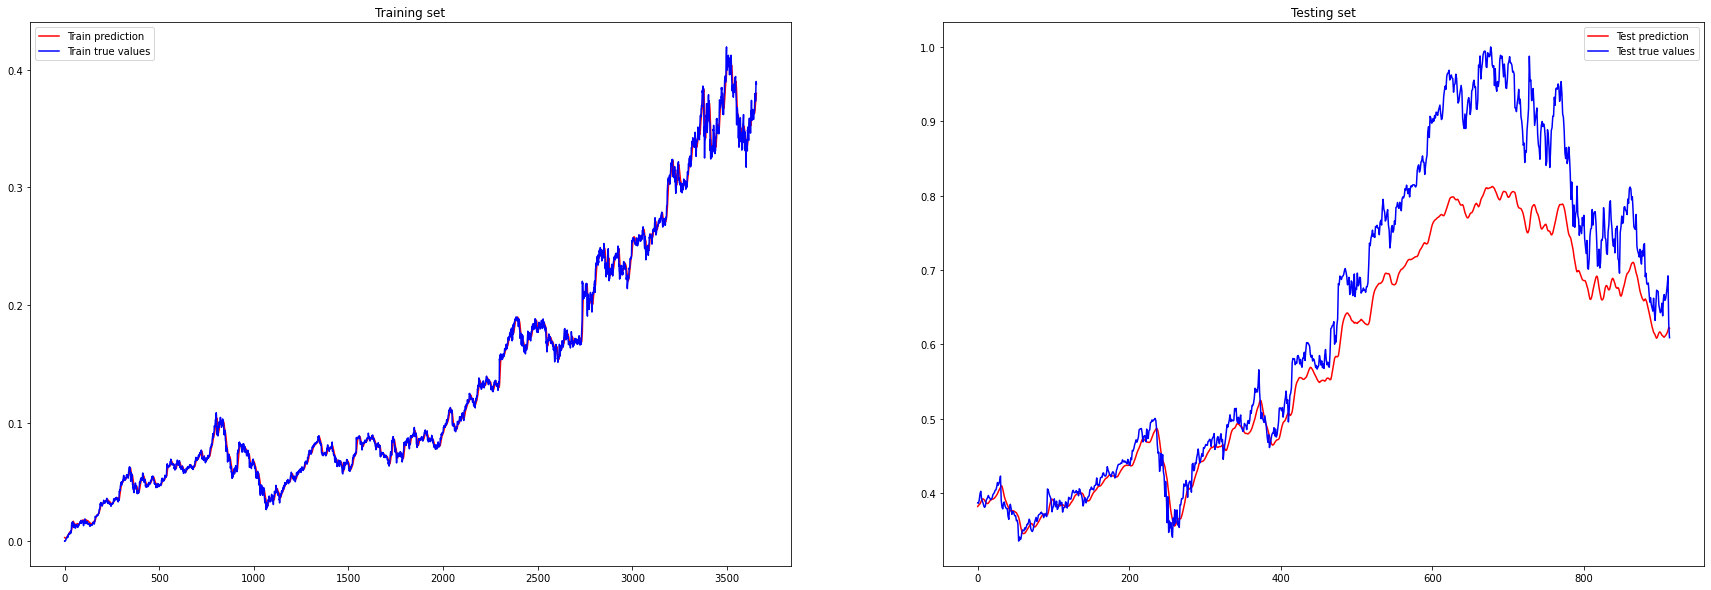

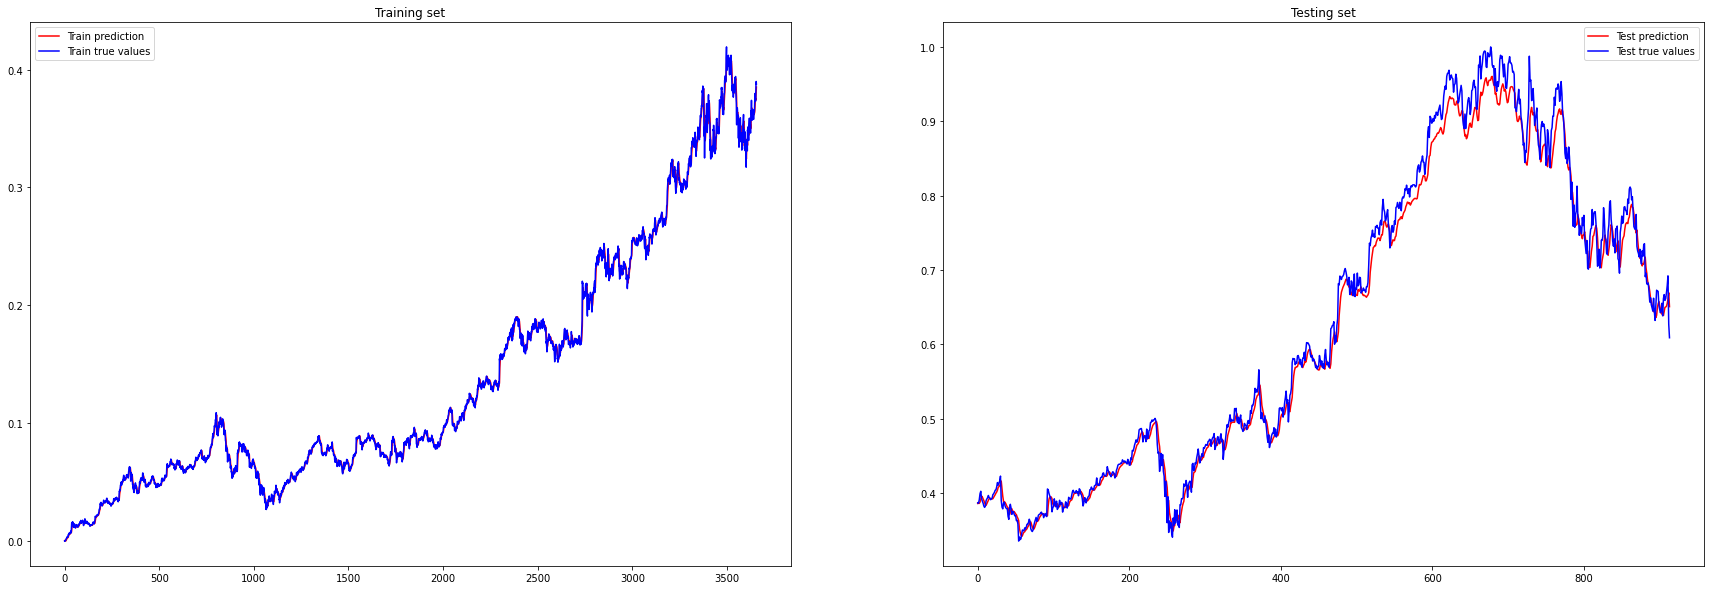

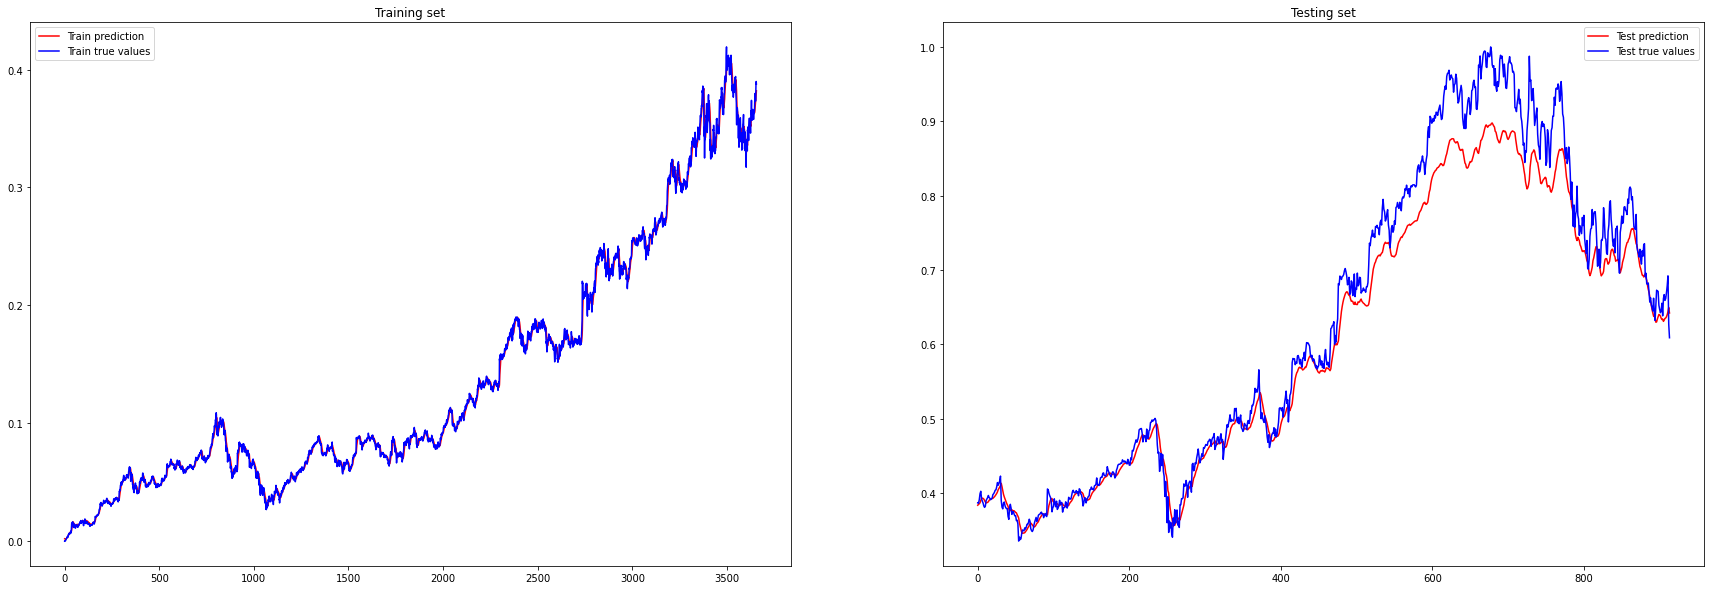

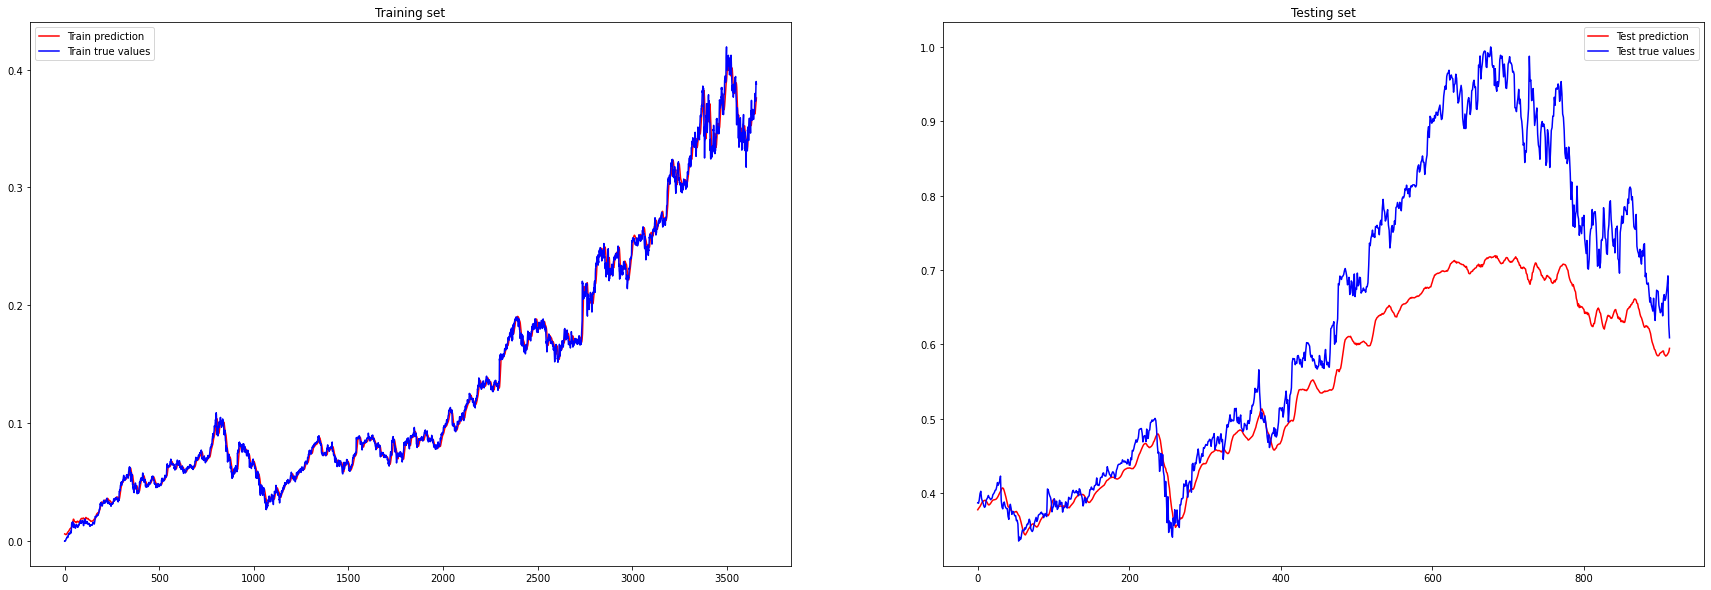

In [106]:
for hs in hidden_size:
    for nl in num_layers:
        print("Current gru model: ")
        print("Number of layers: {}, Hidden sizes: {}".format(nl, hs))
        test_gru = GRUnet(input_size, hs, nl)   
        trained_gru_test, test_gru_loss = train_model(test_gru, verbose=0)
        plot_prediction(trained_gru_test)
        print()